# 📊 Caderno de Análises — EDA Completa (Planos de Saúde)
**Objetivo:** executar uma EDA padronizada com foco em custos e risco.

**Inclui:** heatmap de ausentes corrigido, matrizes de correlação (geral, risk_score, is_high_risk), pizzas para binárias, gráficos originais e tabelas multivariáveis.


## 0) Ambiente e requisitos
- Python 3.10+
- `pandas`, `numpy`, `seaborn`, `matplotlib`

Se necessário:
```bash
pip install pandas numpy seaborn matplotlib
```

In [21]:

# === 1) Configurações gerais ===
from pathlib import Path

CSV_PATH = Path("/Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv")
# CSV_PATH = Path("/mnt/data/full_warehouse_merged.csv")

TARGET_CANDIDATES = ["annual_medical_cost", "annual_premium", "monthly_premium"]
MAX_PAIRPLOT_VARS = 8
MAX_SCATTERS = 10
MAX_BOXPLOTS = 12
LOW_CARDINALITY_MAX = 30
SAMPLE_FOR_SCATTER = 8000
SAVE_FIGS = False
FIG_DPI = 110

TOPN_RISK = 15
MAX_PIES_BINARIES = 999
MISSING_TOKENS_STR = {"no_data", "nd", "na", "n/a", "sem_dado", "sem_dados", ""}
MISSING_TOKENS_NUM = {-1, -1.0}


In [22]:

# === 2) Imports ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

sns.set(style="whitegrid", palette="viridis", font_scale=1.05)


In [23]:

# === 3) Helpers gerais ===
def tight_title(title, width=80):
    import textwrap as _tw
    return "\n".join(_tw.wrap(title, width=width))

def ensure_figdir():
    out = Path("figs"); out.mkdir(exist_ok=True); return out

def savefig_maybe(name):
    if SAVE_FIGS:
        outdir = ensure_figdir()
        plt.savefig(outdir / f"{name}.png", dpi=FIG_DPI, bbox_inches="tight")

def detect_columns(df: pd.DataFrame):
    n_rows = len(df)
    id_like = []
    for c in df.columns:
        cname = c.lower()
        nunq = df[c].nunique(dropna=False)
        if ("id" in cname) or (df[c].dtype == "object" and nunq >= 0.9 * n_rows):
            id_like.append(c)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    for c in num_cols:
        if df[c].nunique() <= LOW_CARDINALITY_MAX and c not in id_like:
            if c not in cat_cols:
                cat_cols.append(c)
    num_cols = [c for c in num_cols if c not in id_like]
    cat_cols = [c for c in cat_cols if c not in id_like]
    return id_like, num_cols, cat_cols

def pick_target(df, candidates):
    for c in candidates:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            return c
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        return None
    corr = df[num_cols].corr(numeric_only=True).abs().mean().sort_values(ascending=False)
    return corr.index[0]


In [24]:

# === 4) Ausentes (corrigido) e correlações ===
def build_missing_mask(df: pd.DataFrame) -> pd.DataFrame:
    mask = pd.DataFrame(False, index=df.index, columns=df.columns)
    for c in df.columns:
        s = df[c]
        colmask = s.isna()
        if pd.api.types.is_numeric_dtype(s):
            colmask |= s.isin(MISSING_TOKENS_NUM)
        else:
            s_str = s.astype(str).str.strip().str.lower()
            colmask |= s_str.isin(MISSING_TOKENS_STR)
        mask[c] = colmask
    return mask

def plot_missingness(df):
    miss = build_missing_mask(df)
    if len(miss) > 2000:
        miss = miss.sample(2000, random_state=42)
    plt.figure(figsize=(12, 4))
    sns.heatmap(miss[sorted(miss.columns)], cbar=False)
    plt.title("Mapa de Valores Ausentes por Coluna (tratando -1 / 'no_data' como nulos)")
    plt.xlabel("Colunas"); plt.ylabel("Linhas (amostra)")
    savefig_maybe("01_missingness_heatmap_fixed")
    plt.show()

def plot_correlation_heatmap(df, drop_cols=None, title_suffix=""):
    drop_cols = drop_cols or []
    corr = df.drop(columns=drop_cols, errors="ignore").corr(numeric_only=True)
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
    plt.title(tight_title(f"Matriz de Correlação entre Variáveis Numéricas {title_suffix}"))
    savefig_maybe(f"02_corr_heatmap_full{title_suffix.replace(' ', '_')}")
    plt.show()
    return corr

def plot_top_corr_with_target(corr, target, topn=15):
    if target not in corr.columns:
        print(f"[aviso] alvo '{target}' não está na matriz de correlação.")
        return []
    s = corr[target].drop(labels=[target], errors="ignore").abs().sort_values(ascending=False)
    top_vars = s.head(topn).index.tolist()
    print("\nTop correlações absolutas com o alvo:", target)
    print(s.head(topn))
    return top_vars


In [25]:

# === 5) Gráficos originais ===
def plot_distributions(df, num_cols):
    for c in num_cols:
        plt.figure(figsize=(8,5))
        sns.histplot(df[c], kde=True, bins=30)
        plt.title(tight_title(f"Distribuição de {c}"))
        plt.xlabel(c)
        savefig_maybe(f"03_dist_{c}")
        plt.show()

def plot_countplots(df, cat_cols, limit_each=40):
    for c in cat_cols:
        if df[c].nunique(dropna=False) > limit_each:
            continue
        plt.figure(figsize=(10,5))
        order = df[c].value_counts(dropna=False).index
        sns.countplot(data=df, x=c, order=order)
        plt.title(tight_title(f"Contagem por {c}"))
        plt.xticks(rotation=45, ha="right")
        savefig_maybe(f"04_count_{c}")
        plt.tight_layout(); plt.show()

def plot_boxplots_cat_target(df, cat_cols, target, max_plots=12, limit_each=40):
    if target is None:
        return
    plotted = 0
    for c in cat_cols:
        if plotted >= max_plots: break
        if df[c].nunique(dropna=False) > limit_each: continue
        plt.figure(figsize=(10,5))
        sns.boxplot(data=df, x=c, y=target)
        plt.title(tight_title(f"{target} por {c}"))
        plt.xticks(rotation=45, ha="right")
        savefig_maybe(f"05_box_{target}_by_{c}")
        plt.tight_layout(); plt.show()
        plotted += 1

def plot_scatter_with_target(df, num_cols, target, max_plots=10, sample_n=8000):
    if target is None or target not in df.columns:
        return
    corr = df[num_cols + [target]].corr(numeric_only=True)[target].drop(target).abs().sort_values(ascending=False)
    top = corr.index.tolist()[:max_plots]
    data = df if len(df) <= sample_n else df.sample(sample_n, random_state=42)
    for c in top:
        plt.figure(figsize=(8,5))
        sns.regplot(data=data, x=c, y=target, scatter_kws=dict(alpha=0.25, s=12), line_kws=dict())
        plt.title(tight_title(f"{target} vs {c} (com linha de tendência)"))
        savefig_maybe(f"06_scatter_{target}_vs_{c}")
        plt.show()

def plot_pairplot_top(df, target, corr, max_vars=8):
    if target is None or target not in df.columns:
        return
    s = corr[target].drop(labels=[target], errors="ignore").abs().sort_values(ascending=False)
    top_vars = [v for v in s.index.tolist() if pd.api.types.is_numeric_dtype(df[v])]
    vars_to_plot = [target] + top_vars[:max_vars-1]
    data = df[vars_to_plot]
    if len(data) > 4000:
        data = data.sample(4000, random_state=42)
    g = sns.pairplot(data, diag_kind="hist", corner=True)
    g.fig.suptitle(tight_title(f"Pairplot: {target} e variáveis mais correlacionadas"), y=1.02)
    savefig_maybe("07_pairplot_top")
    plt.show()


In [26]:

# === 6) Binárias, risk_score, is_high_risk, multivariadas ===
def _normalize_object_series(s: pd.Series) -> pd.Series:
    if s.dtype == "object":
        return s.astype(str).str.strip().str.lower().replace({
            "sim":"sim","não":"nao","não":"nao","yes":"yes","no":"no",
            "y":"y","n":"n","true":"true","false":"false","t":"t","f":"f",
            "1":"1","0":"0"
        })
    return s

def detect_binary_columns(df: pd.DataFrame, exclude=None):
    exclude = set(exclude or [])
    bin_cols = []
    for c in df.columns:
        if c in exclude: 
            continue
        s = _normalize_object_series(df[c])
        nunq = s.dropna().nunique()
        if nunq == 2:
            bin_cols.append(c)
        else:
            if pd.api.types.is_numeric_dtype(df[c]):
                vals = set(pd.Series(df[c].dropna().unique()).tolist())
                if len(vals) == 2:
                    bin_cols.append(c)
    return bin_cols

def plot_pies_for_binary_columns(df: pd.DataFrame, bin_cols, max_pies=999):
    count = 0
    for c in bin_cols:
        if count >= max_pies: break
        vc = _normalize_object_series(df[c]).value_counts(dropna=False)
        if vc.sum() == 0: continue
        plt.figure(figsize=(5.5,5.5))
        plt.pie(vc.values, labels=[str(k) for k in vc.index], autopct="%1.1f%%", startangle=90)
        plt.title(tight_title(f"Distribuição (pizza) - {c}"))
        plt.axis("equal")
        savefig_maybe(f"08_pie_binary_{c}")
        plt.show()
        count += 1

def plot_corr_matrix_anchor(df: pd.DataFrame, anchor_col: str, topn=15, title_prefix="Foco"):
    if anchor_col not in df.columns:
        print(f"[aviso] '{anchor_col}' não existe."); return pd.DataFrame(), []
    work = df.copy()
    if not pd.api.types.is_numeric_dtype(work[anchor_col]):
        work[anchor_col] = pd.to_numeric(work[anchor_col], errors="coerce")
    num_cols = work.select_dtypes(include=[np.number]).columns.tolist()
    if anchor_col not in num_cols:
        print(f"[aviso] '{anchor_col}' não é numérico após coerção."); return pd.DataFrame(), []
    corr = work[num_cols].corr(numeric_only=True)
    s = corr[anchor_col].drop(labels=[anchor_col], errors="ignore").abs().sort_values(ascending=False)
    top_vars = s.head(topn).index.tolist()
    focus_cols = [anchor_col] + top_vars
    plt.figure(figsize=(8, 6))
    sns.heatmap(work[focus_cols].corr(numeric_only=True), cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.title(tight_title(f"{title_prefix}: matriz de correlação — '{anchor_col}' + top {topn}"))
    savefig_maybe(f"corr_matrix_{anchor_col}_focus")
    plt.show()
    table = pd.DataFrame({
        "variavel": s.index,
        "correlacao": corr[anchor_col].drop(anchor_col, errors="ignore")[s.index].values,
        "abs_correlacao": s.values
    }).head(topn)
    return table, top_vars

def corr_with_binary_anchor(df: pd.DataFrame, bin_col: str, topn=15):
    if bin_col not in df.columns:
        print(f"[aviso] '{bin_col}' não existe."); return pd.DataFrame()
    work = df.copy()
    s = work[bin_col]
    if not pd.api.types.is_numeric_dtype(s):
        s = _normalize_object_series(s).replace({"true":1,"yes":1,"y":1,"1":1,
                                                 "false":0,"no":0,"n":0,"0":0})
    work[bin_col] = pd.to_numeric(s, errors="coerce")
    num_cols = work.select_dtypes(include=[np.number]).columns.tolist()
    if bin_col not in num_cols:
        print(f"[aviso] '{bin_col}' não pôde ser binarizado."); return pd.DataFrame()
    corrs = work[num_cols].corr(numeric_only=True)[bin_col].drop(labels=[bin_col], errors="ignore")
    table = (pd.DataFrame({"variavel": corrs.index,
                           "correlacao": corrs.values,
                           "abs_correlacao": np.abs(corrs.values)})
             .sort_values("abs_correlacao", ascending=False)
             .head(topn))
    return table

def _first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def multivar_tables(df: pd.DataFrame,
                    cost_col="annual_medical_cost",
                    risk_col="risk_score"):
    out = {}
    if cost_col not in df.columns or risk_col not in df.columns:
        return out
    risk = pd.to_numeric(df[risk_col], errors="coerce")
    if risk.nunique(dropna=True) >= 10:
        bins = pd.qcut(risk, 10, labels=[f"D{i}" for i in range(1,11)])
    else:
        bins = pd.qcut(risk, 4, labels=[f"Q{i}" for i in range(1,5)])
    df2 = df.copy()
    df2["risk_bin"] = bins

    c_plan   = _first_existing(df2, ["plan_type", "plan", "product"])
    c_tier   = _first_existing(df2, ["network_tier", "network", "tier"])
    c_region = _first_existing(df2, ["region"])
    c_sex    = _first_existing(df2, ["sex", "gender"])

    out["by_risk_bin"] = (df2.groupby("risk_bin", dropna=True)[cost_col]
                             .agg(["count","mean","median","std"]).reset_index())

    if c_plan:
        out["plan_x_risk"] = (df2.pivot_table(index=c_plan, columns="risk_bin",
                                              values=cost_col, aggfunc="mean").reset_index())
    if c_plan and c_tier:
        out["plan_tier_x_risk"] = (df2.pivot_table(index=[c_plan, c_tier], columns="risk_bin",
                                                   values=cost_col, aggfunc="mean").reset_index())
    if c_region:
        out["region_x_risk"] = (df2.pivot_table(index=c_region, columns="risk_bin",
                                                values=cost_col, aggfunc="mean").reset_index())
    if c_sex:
        out["sex_x_risk"] = (df2.pivot_table(index=c_sex, columns="risk_bin",
                                             values=cost_col, aggfunc="mean").reset_index())

    for name, tbl in out.items():
        p = Path(f"table_{name}.csv")
        tbl.to_csv(p, index=False)
        print(f"[ok] salvo: {p.resolve()}")

    return out


In [27]:

# === 7) Carrega dados e pré-visualiza ===
print(f"Lendo: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
print("Formato:", df.shape)
df.head()


Lendo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv
Formato: (64800, 59)


person_id  annual_medical_cost  annual_premium  monthly_premium  \
0          1               839.85          290.63            24.22   
1          2               709.72          278.13            23.18   
2          3              1589.27          372.57            31.05   
3          4              3246.81          677.54            56.46   
4          6              1462.55          350.40            29.20   

   claims_count  avg_claim_amount  total_claims_paid  hypertension  diabetes  \
0           1.0            410.76             410.76             0         0   
1           1.0            269.00             269.00             0         0   
2           4.0            270.00            1080.00             1         0   
3           0.0              0.00               0.00             0         0   
4           3.0            219.58             658.74             1         0   

   asthma  ...  proc_imaging_count  proc_surgery_count  proc_physio_count  \
0       0  ...                   2                   0                  1   
1       0  ...                   0                   0                  0   
2       0  ...                   0                   0                  1   
3       0  ...                   0                   0                  0   
4       0  ...                   0                   0                  1   

   proc_consult_count  proc_lab_count  had_major_procedure        cost_id  \
0                   0               0                    0  cost_id_31150   
1                   0               0                    0  cost_id_61371   
2                   0               0                    0  cost_id_63662   
3                   1               2                    0  cost_id_17436   
4                   0               0                    0  cost_id_59155   

         policy_id        record_id        visit_id  
0  policy_id_00033  record_id_36092  visit_id_40611  
1  policy_id_00119  record_id_45363  visit_id_48818  
2  policy_id_00176  record_id_64734  visit_id_01246  
3  policy_id_00112  record_id_43770  visit_id_47786  
4  policy_id_00017  record_id_61337  visit_id_35905  

[5 rows x 59 columns]

In [28]:

# === 8) Detecta colunas e variáveis binárias ===
id_like, num_cols, cat_cols = detect_columns(df)
print("\nColunas ID-like:", id_like[:20], "..." if len(id_like) > 20 else "")
print("Numéricas:", num_cols[:10], "..." if len(num_cols) > 10 else "")
print("Categóricas:", cat_cols[:10], "..." if len(cat_cols) > 10 else "")
bin_cols = detect_binary_columns(df, exclude=id_like)
print("Binárias detectadas:", bin_cols[:30], "..." if len(bin_cols) > 30 else "")



Colunas ID-like: ['person_id', 'total_claims_paid', 'kidney_disease', 'provider_quality', 'cost_id', 'policy_id', 'record_id', 'visit_id'] 
Numéricas: ['annual_medical_cost', 'annual_premium', 'monthly_premium', 'claims_count', 'avg_claim_amount', 'hypertension', 'diabetes', 'asthma', 'copd', 'cardiovascular_disease'] ...
Categóricas: ['plan_type', 'network_tier', 'sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status', 'smoker', 'alcohol_freq'] ...
Binárias detectadas: ['hypertension', 'diabetes', 'asthma', 'copd', 'cardiovascular_disease', 'cancer_history', 'liver_disease', 'arthritis', 'mental_health', 'is_high_risk', '_income_outlier_flag', 'had_major_procedure'] 


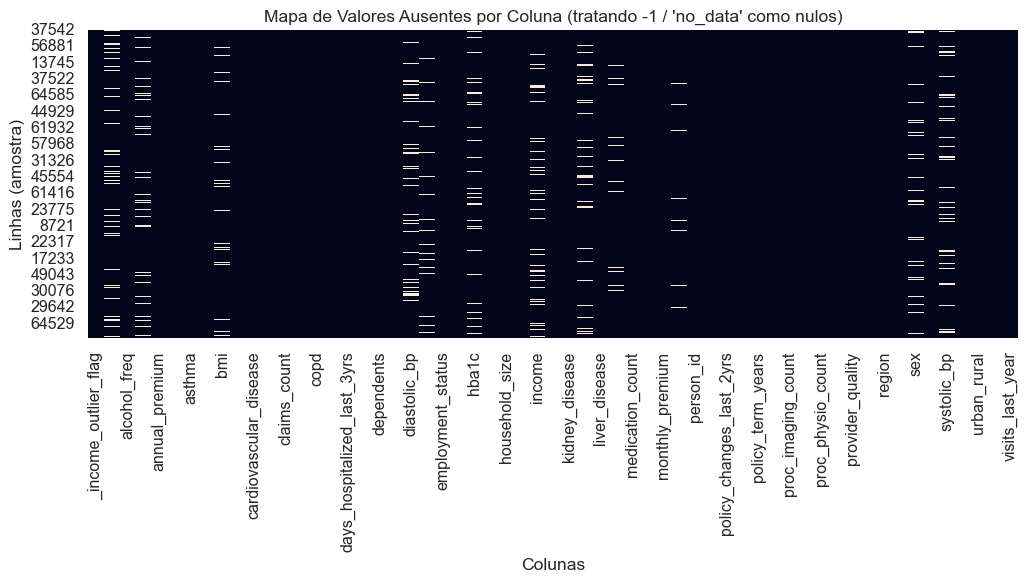

In [29]:

# === 9) Heatmap de ausentes (corrigido) ===
plot_missingness(df)


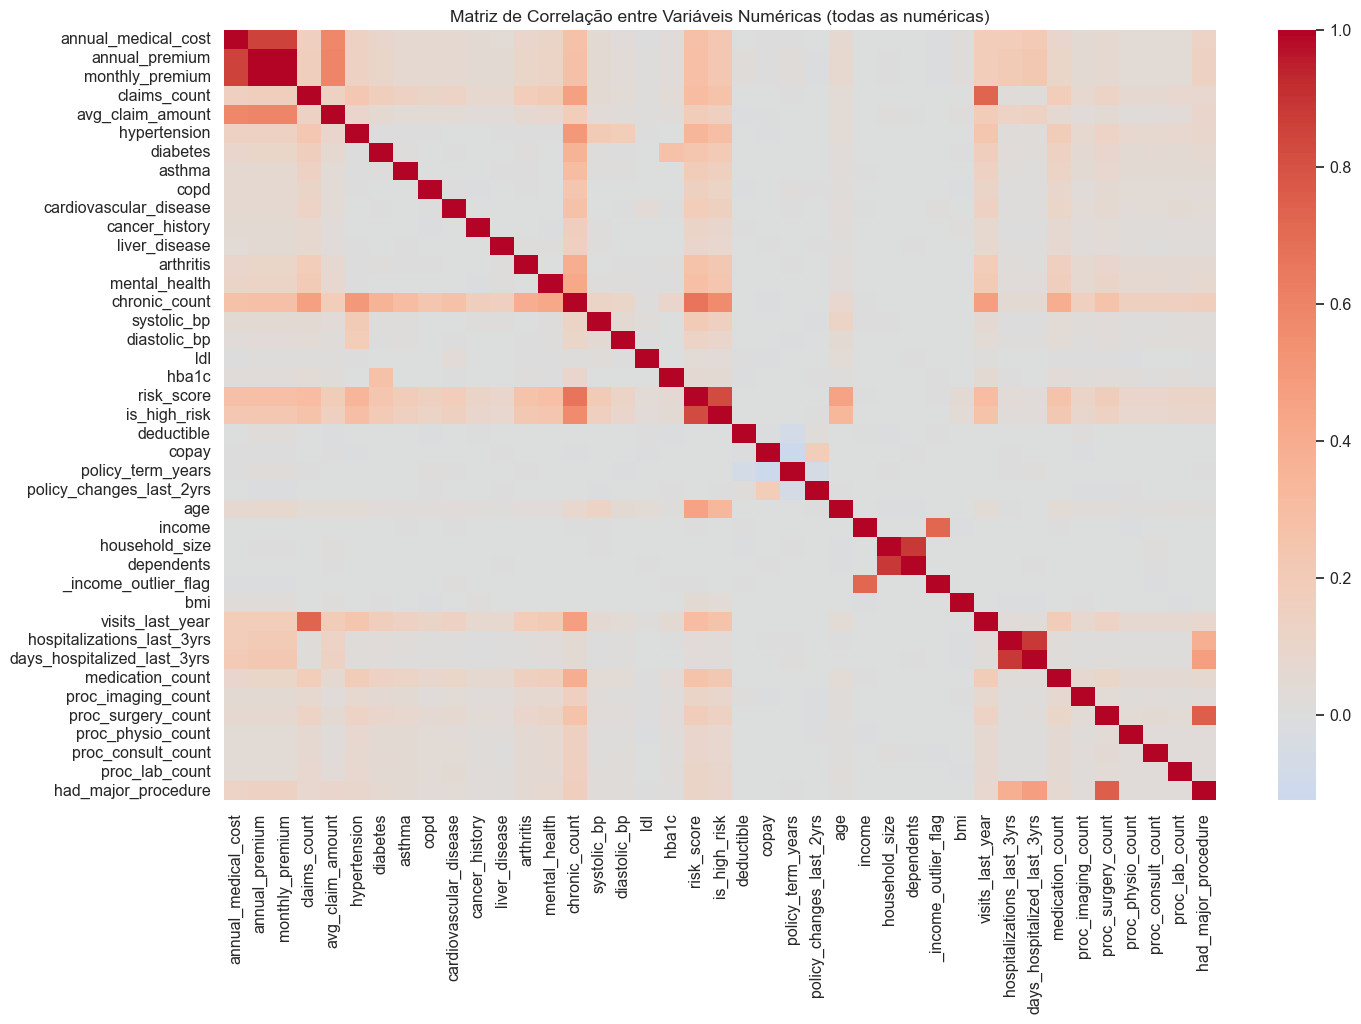

In [30]:

# === 10) Matriz de correlação (todas numéricas) ===
corr_full = plot_correlation_heatmap(df, drop_cols=id_like, title_suffix="(todas as numéricas)")


Alvo selecionado: annual_medical_cost

Top correlações absolutas com o alvo: annual_medical_cost
annual_premium                 0.855609
monthly_premium                0.855609
avg_claim_amount               0.578975
risk_score                     0.276581
chronic_count                  0.269804
is_high_risk                   0.227714
days_hospitalized_last_3yrs    0.207844
hospitalizations_last_3yrs     0.187048
visits_last_year               0.179127
claims_count                   0.161566
hypertension                   0.142044
had_major_procedure            0.133307
mental_health                  0.116688
medication_count               0.103851
diabetes                       0.100780
Name: annual_medical_cost, dtype: float64


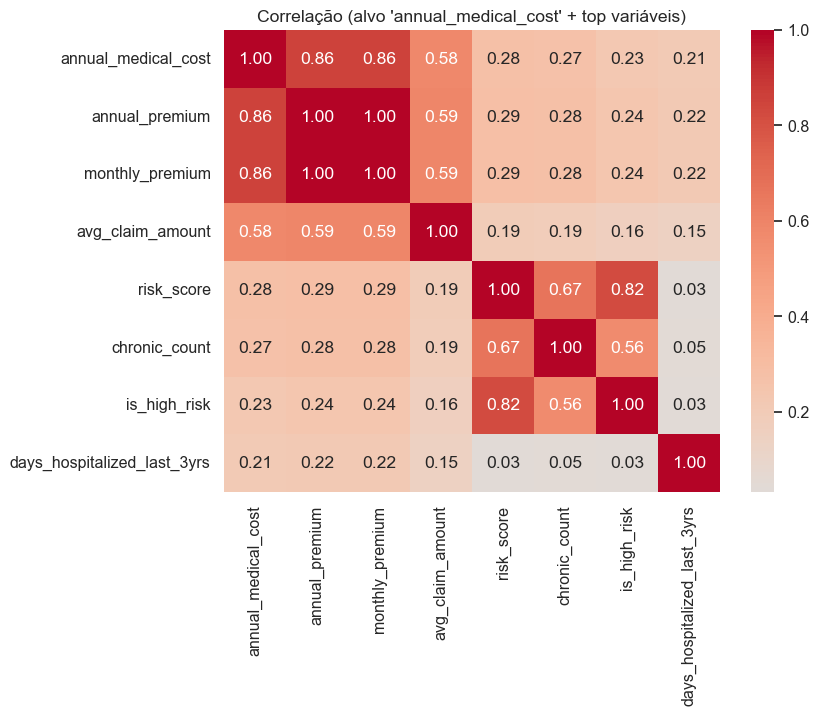

In [31]:

# === 11) Alvo escolhido + heatmap focado ===
target = pick_target(df, TARGET_CANDIDATES)
print(f"Alvo selecionado: {target}")
if target:
    top_vars = plot_top_corr_with_target(corr_full, target, topn=15)
    focus_cols = [target] + top_vars[:MAX_PAIRPLOT_VARS-1]
    focus_corr = df[focus_cols].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(focus_corr, cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.title(tight_title(f"Correlação (alvo '{target}' + top variáveis)"))
    savefig_maybe("02b_corr_heatmap_target_focus")
    plt.show()


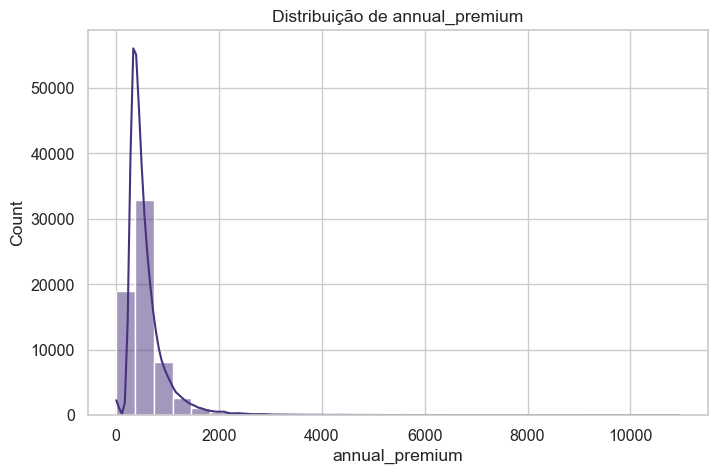

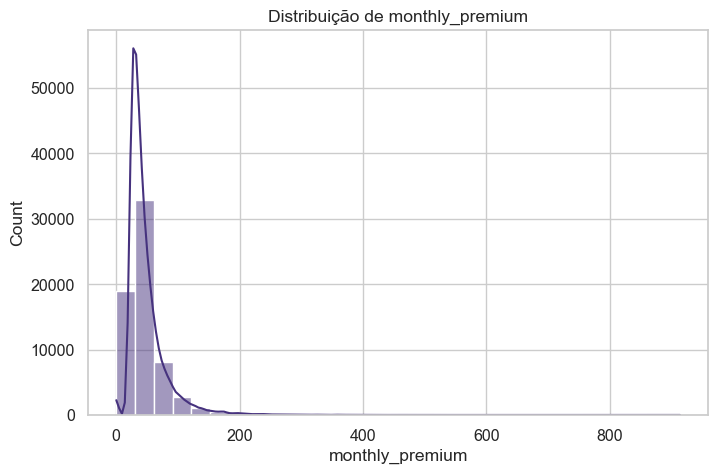

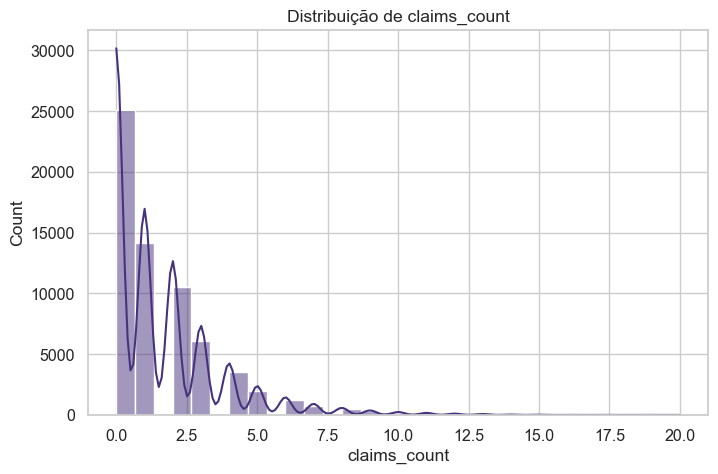

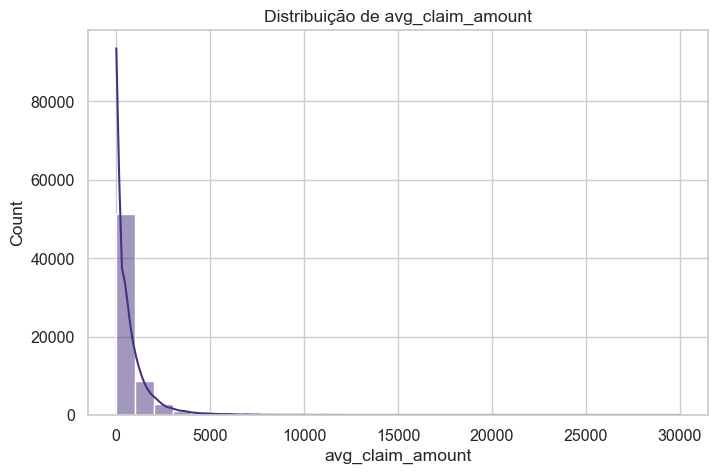

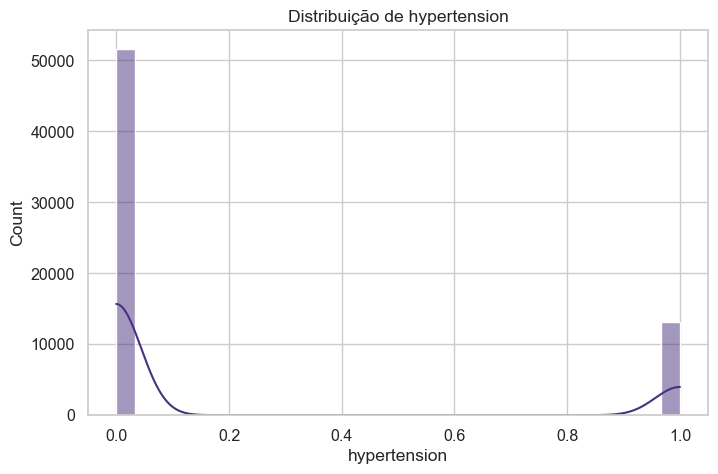

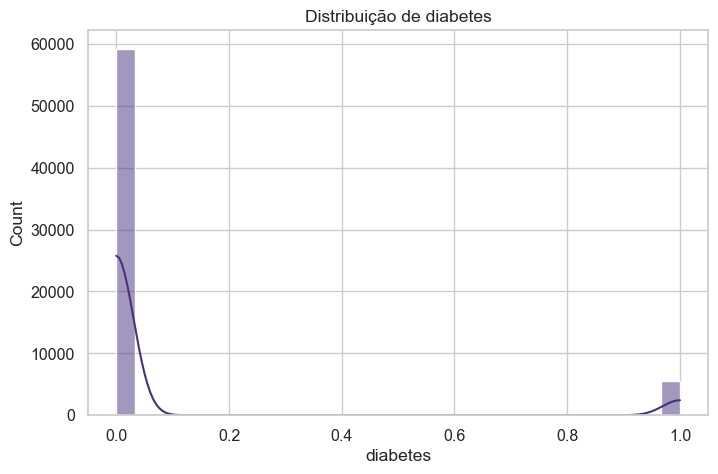

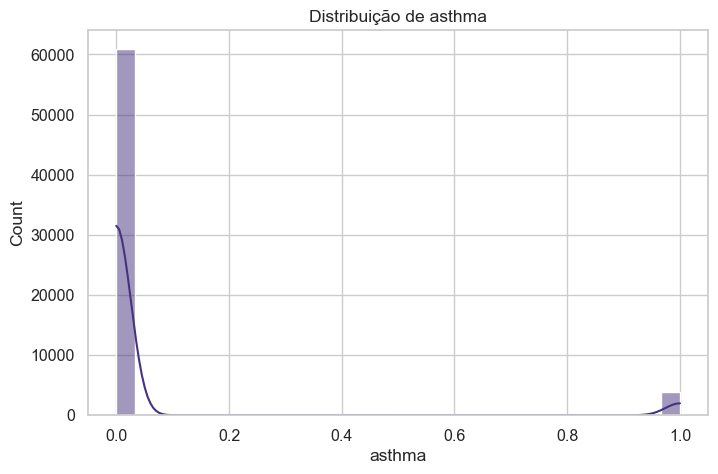

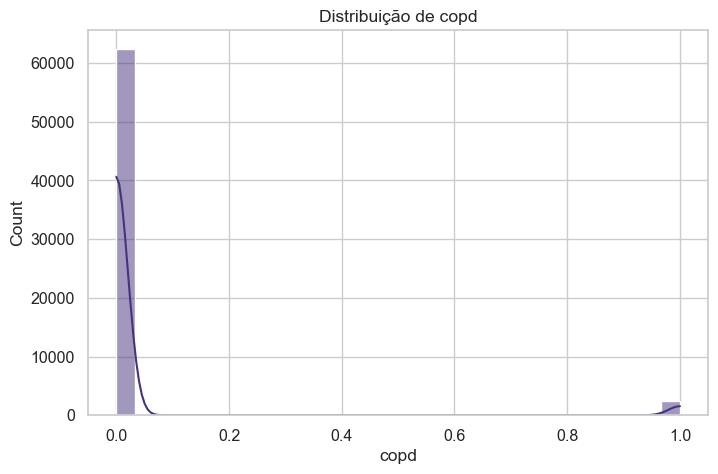

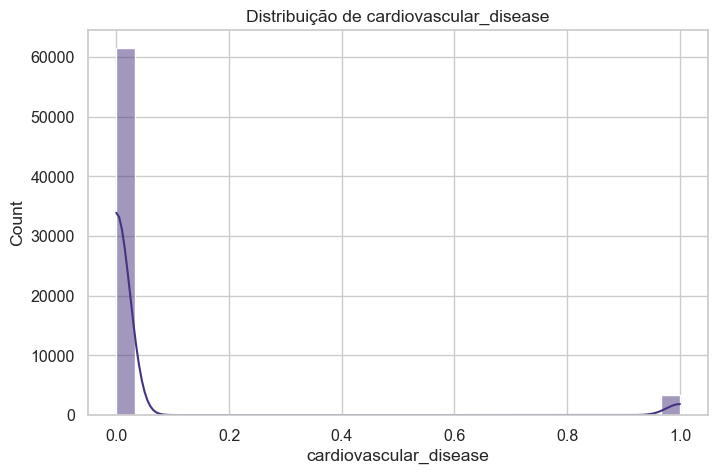

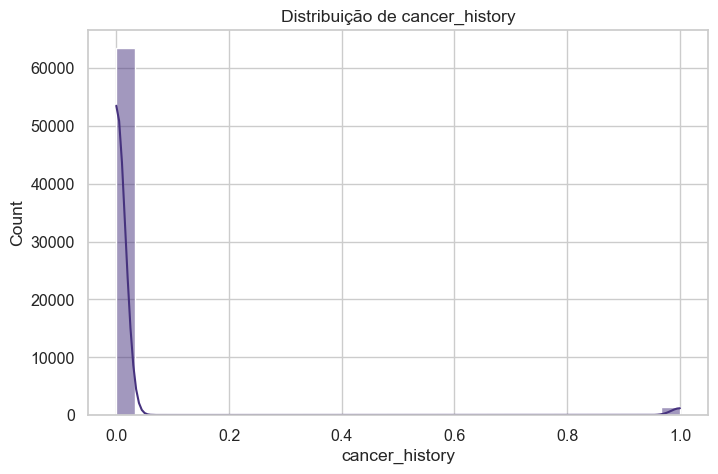

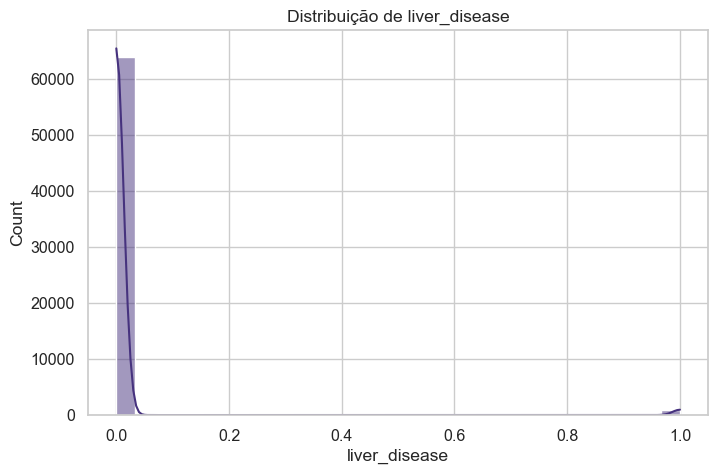

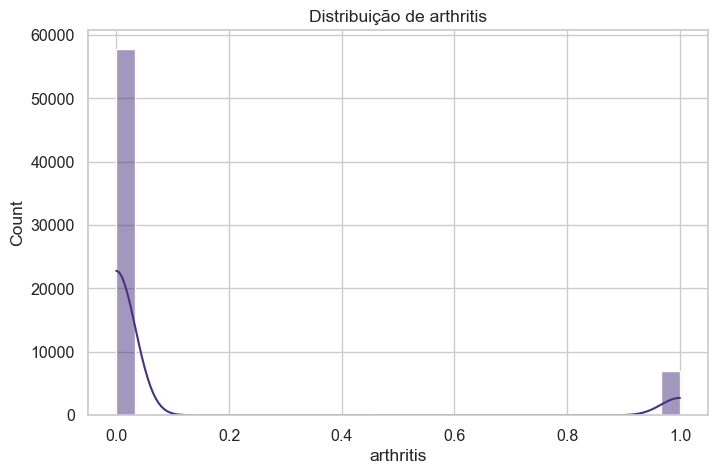

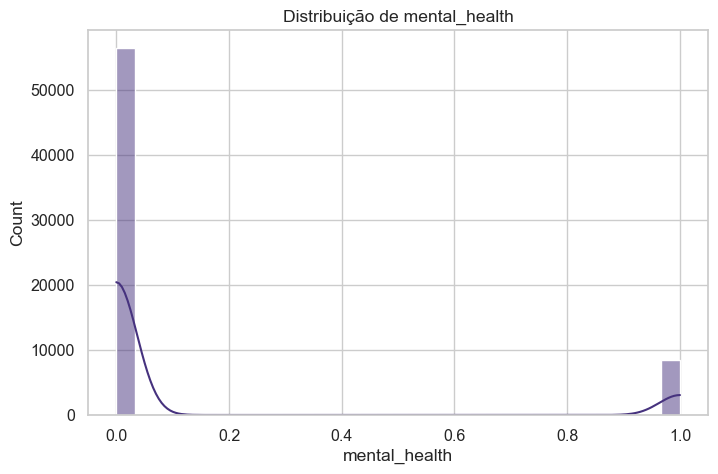

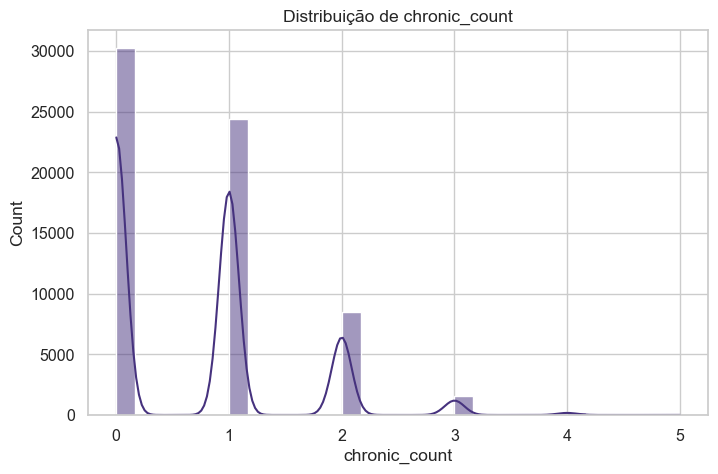

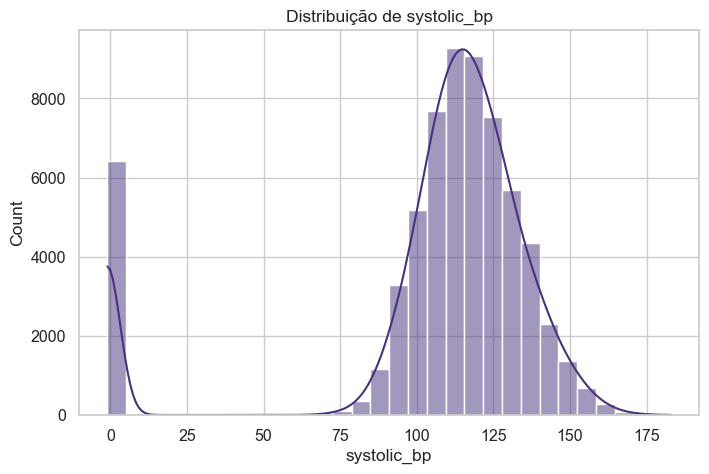

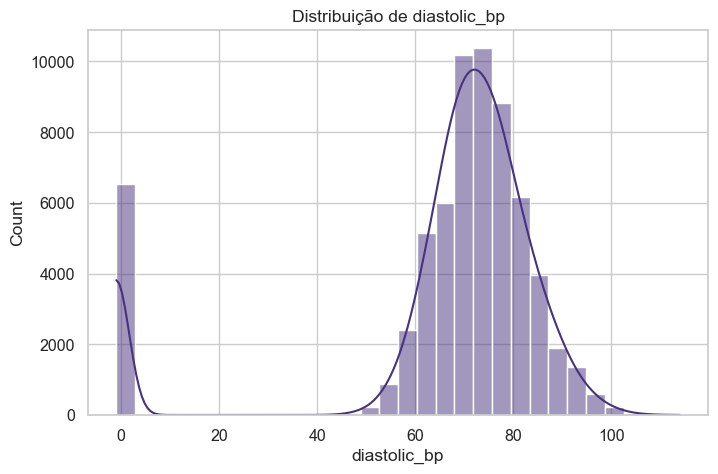

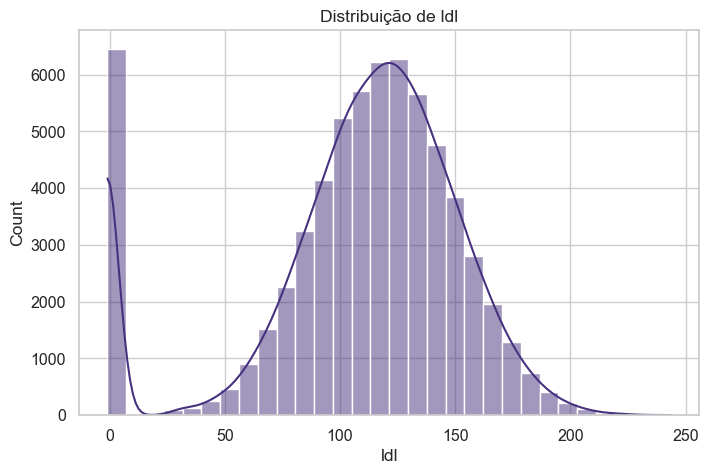

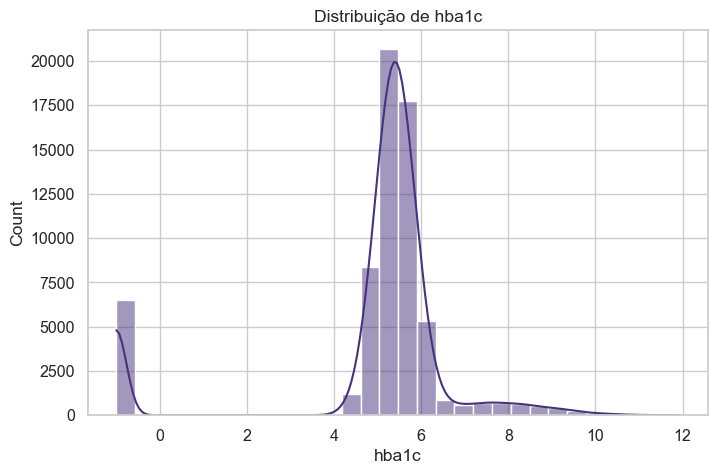

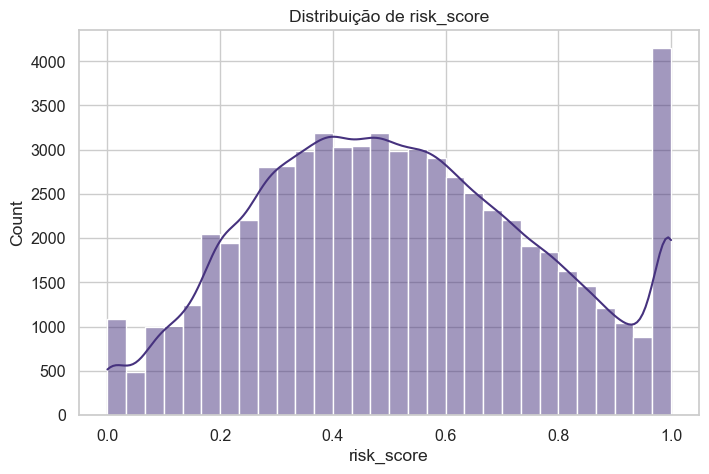

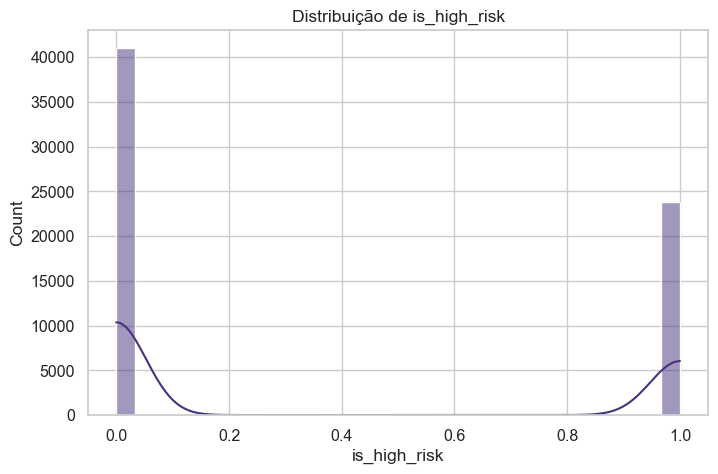

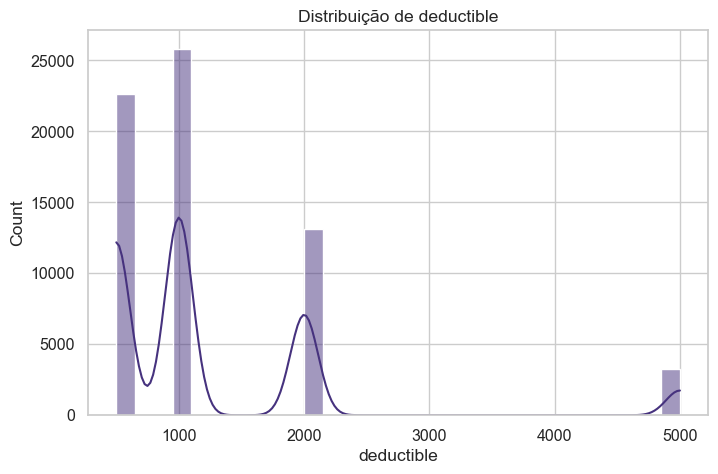

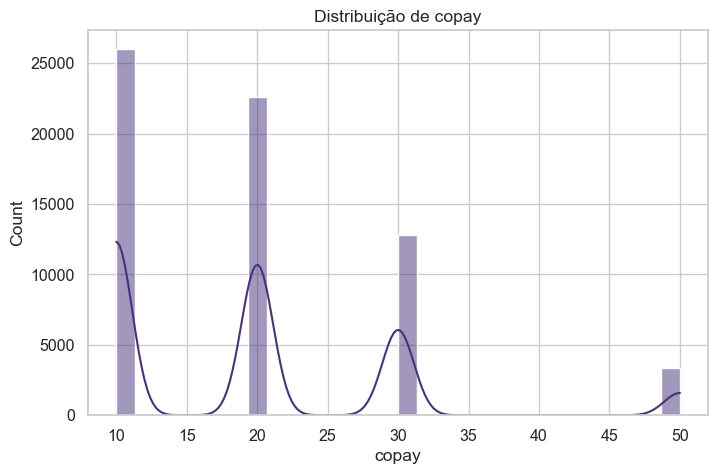

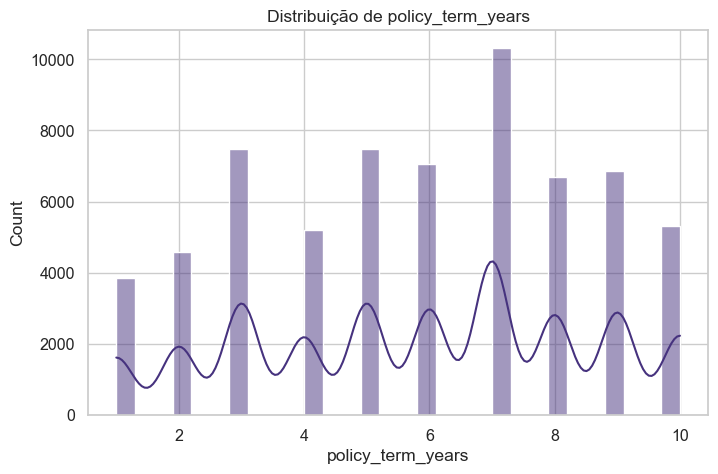

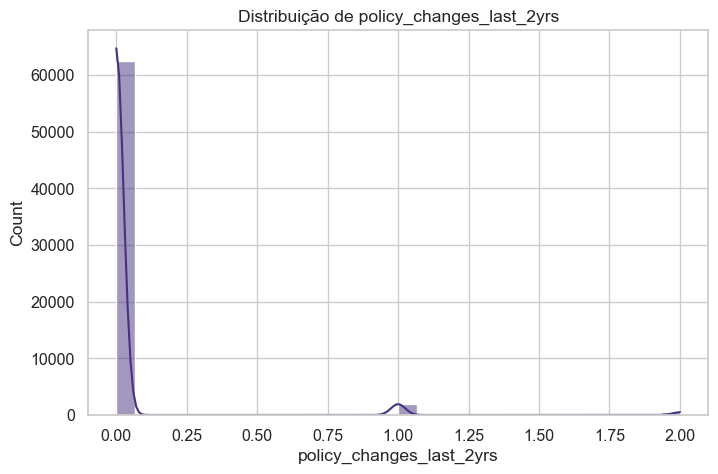

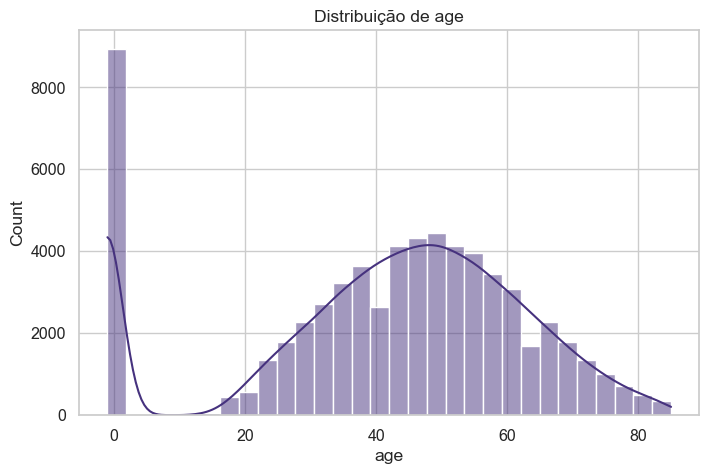

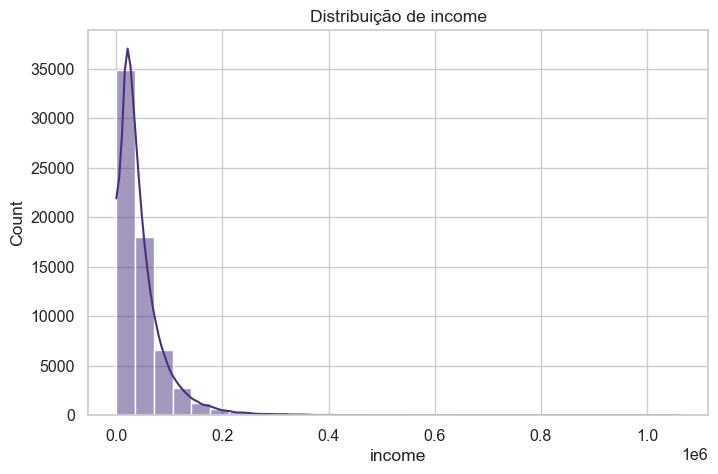

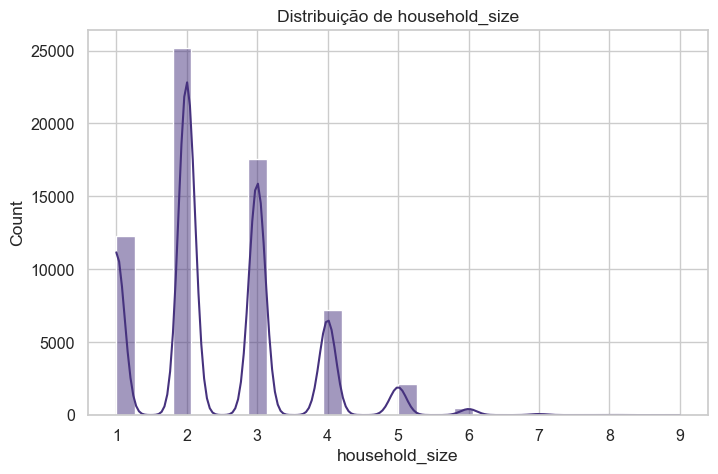

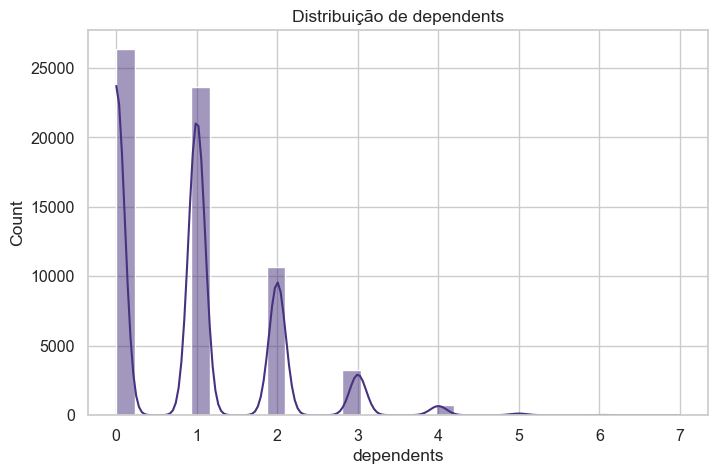

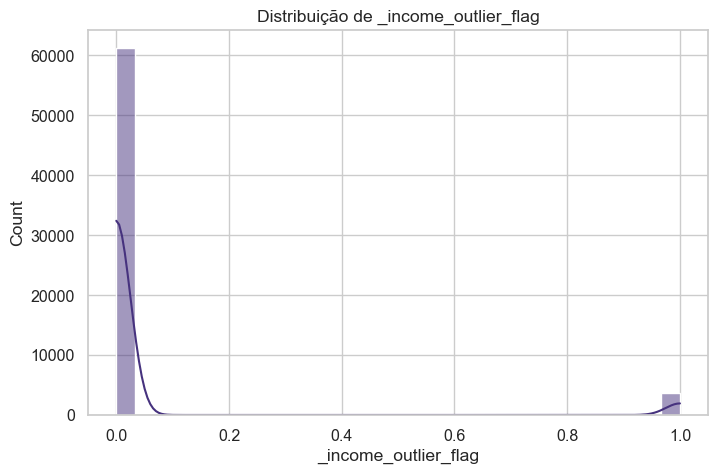

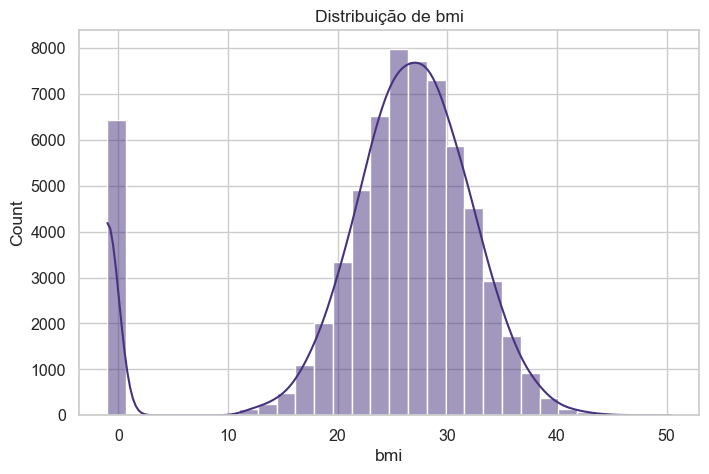

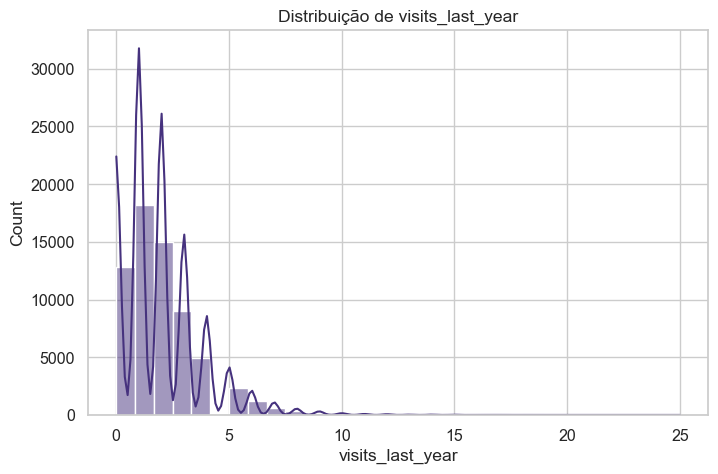

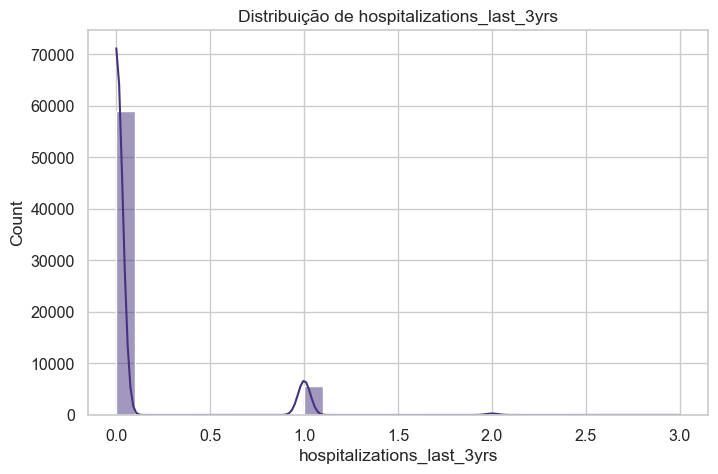

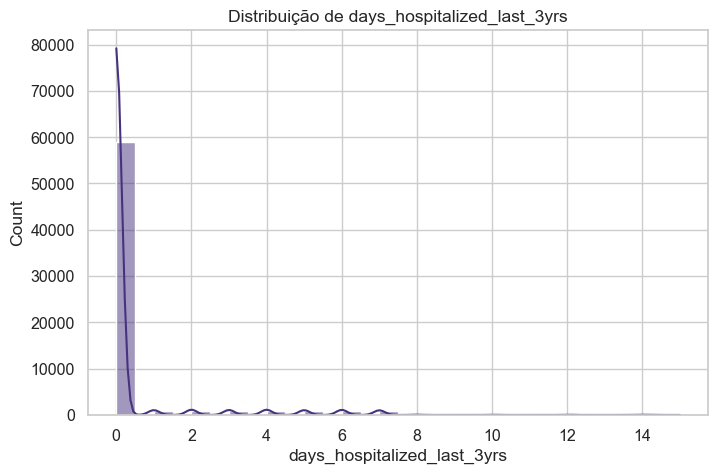

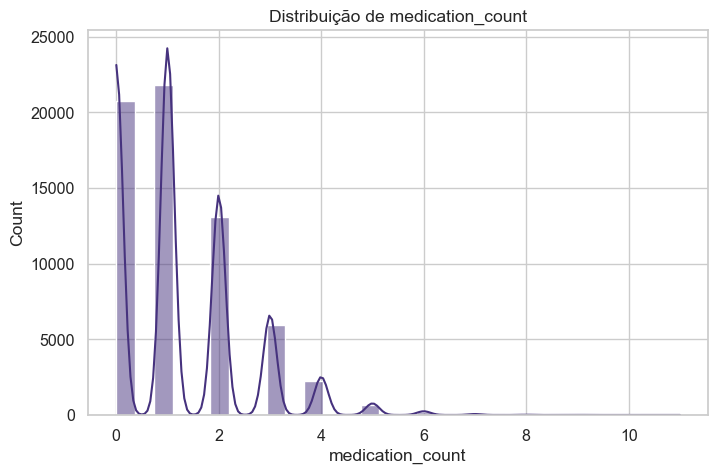

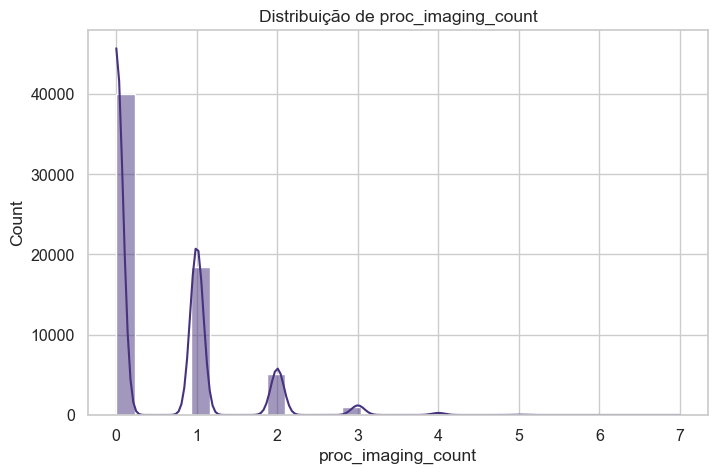

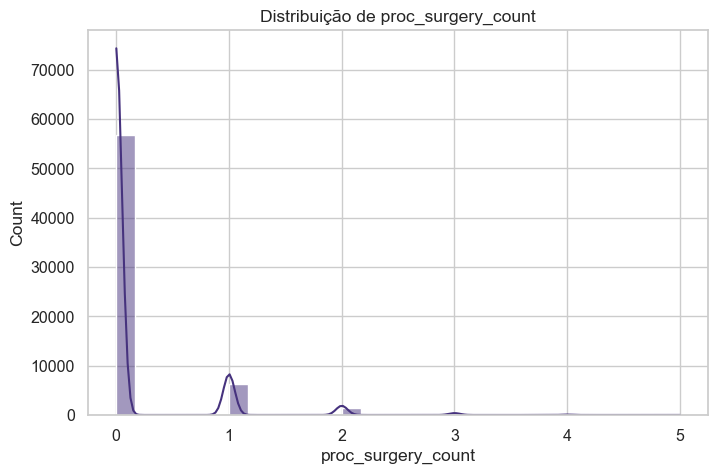

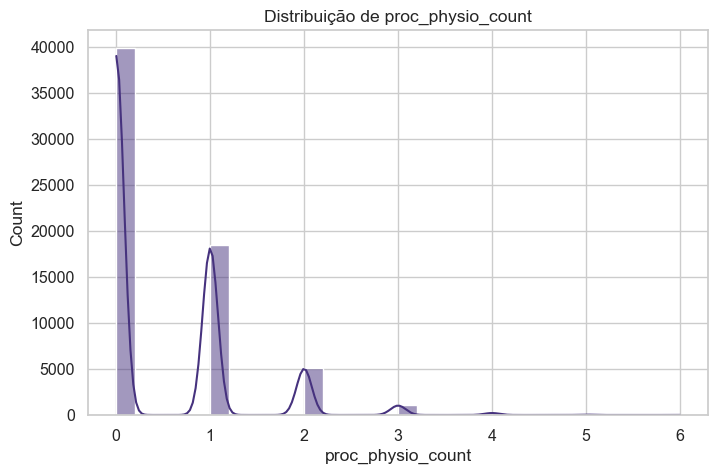

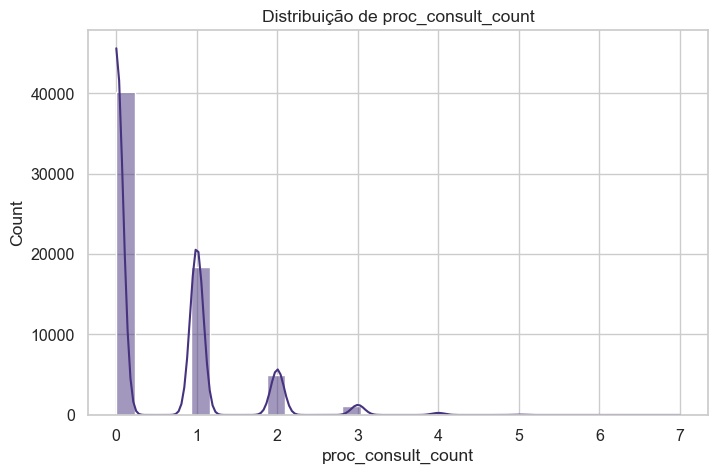

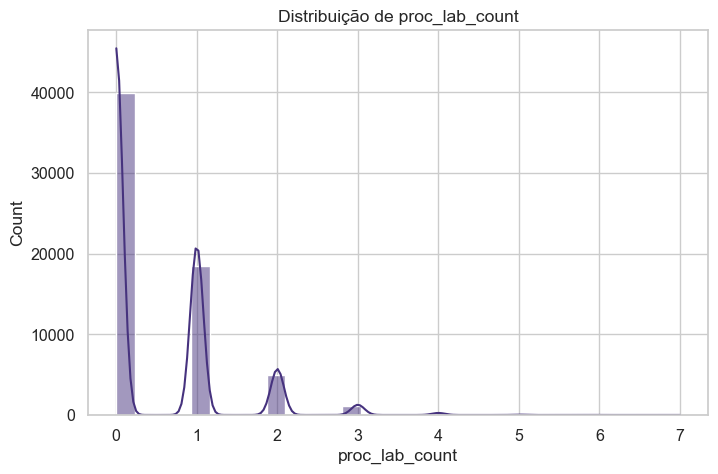

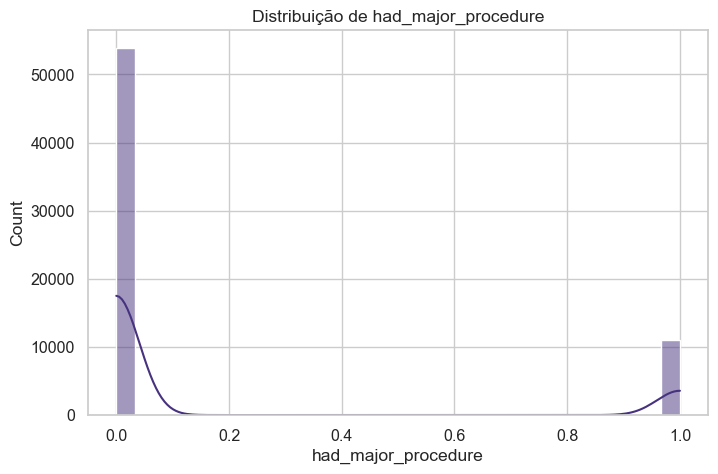

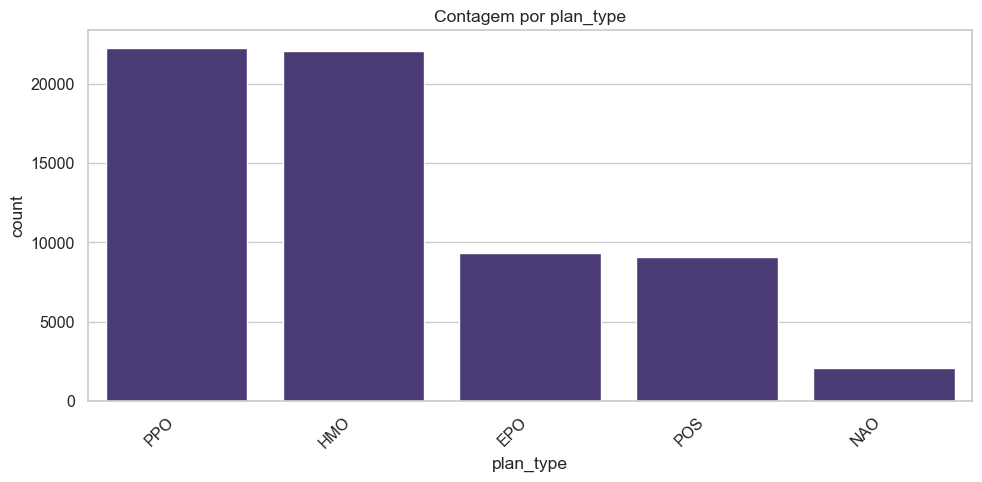

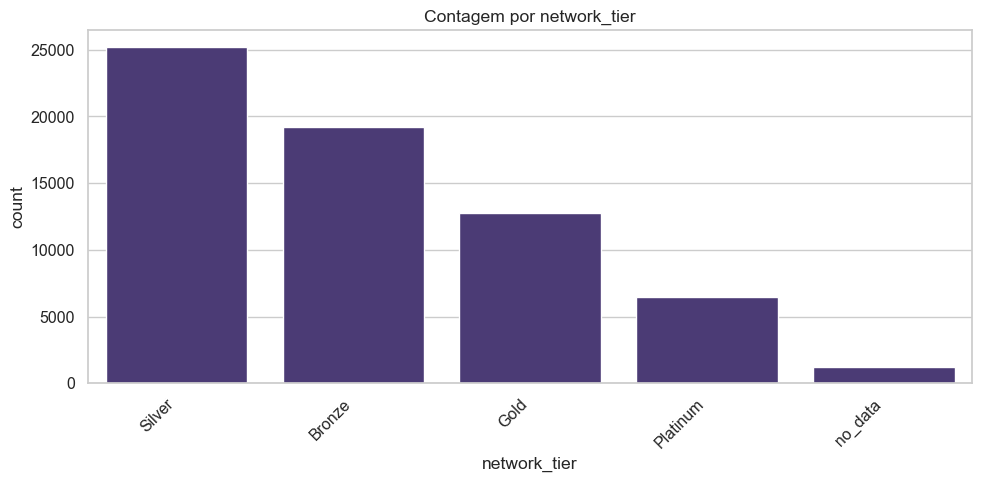

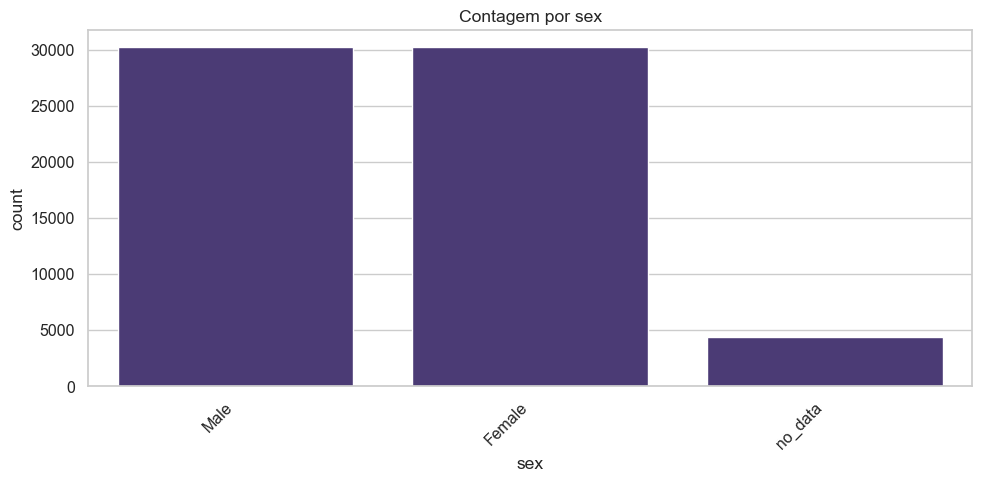

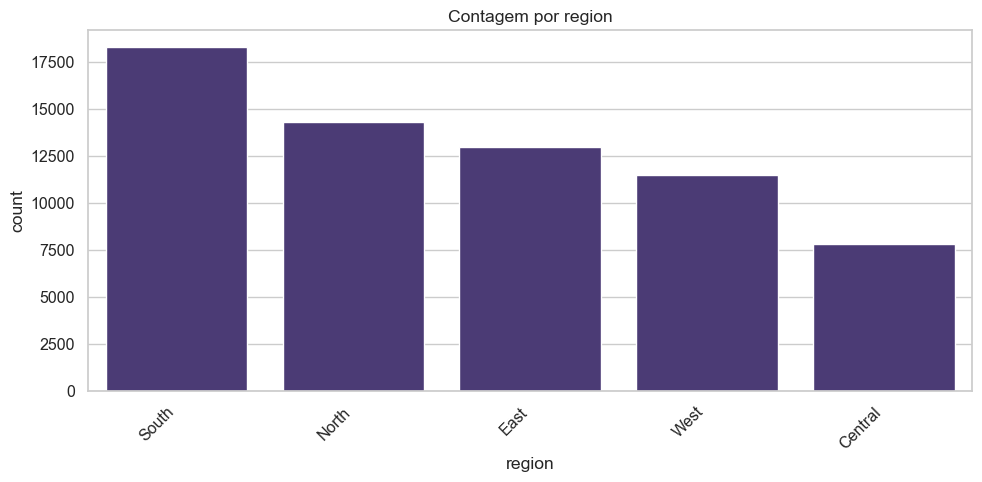

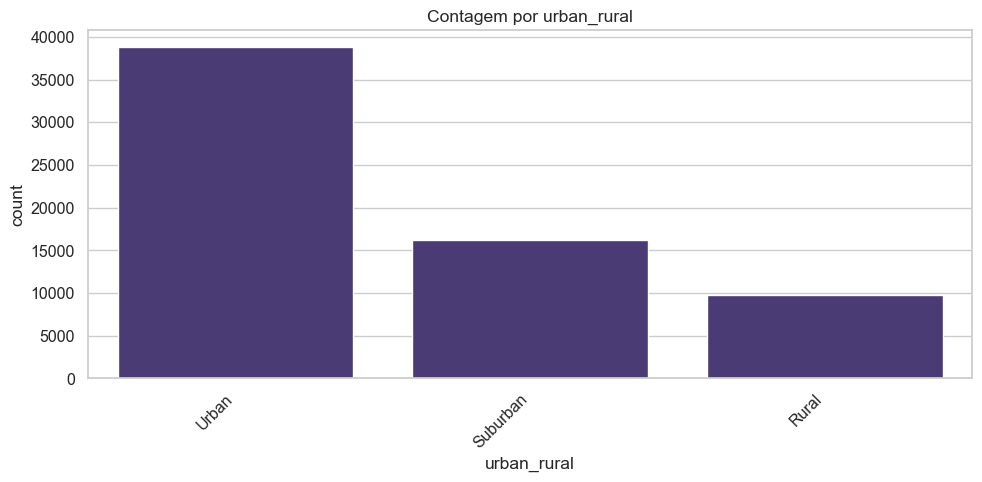

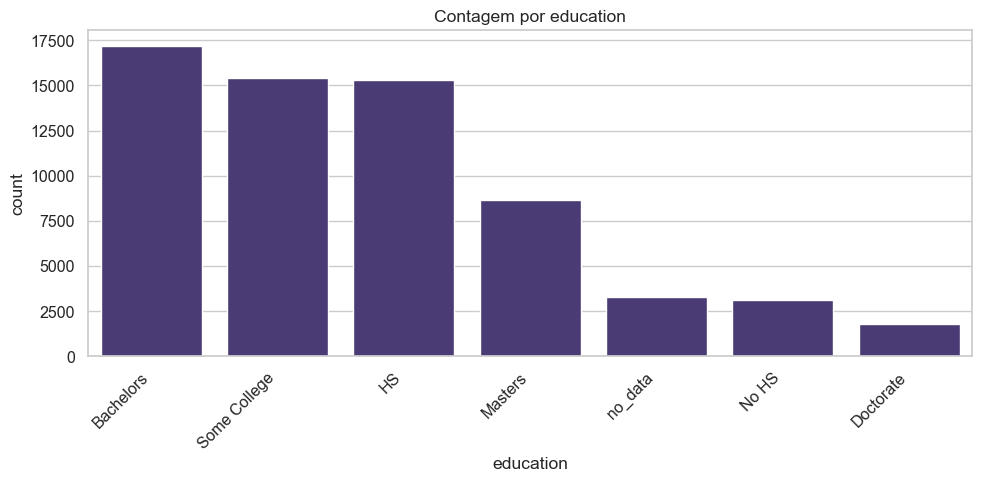

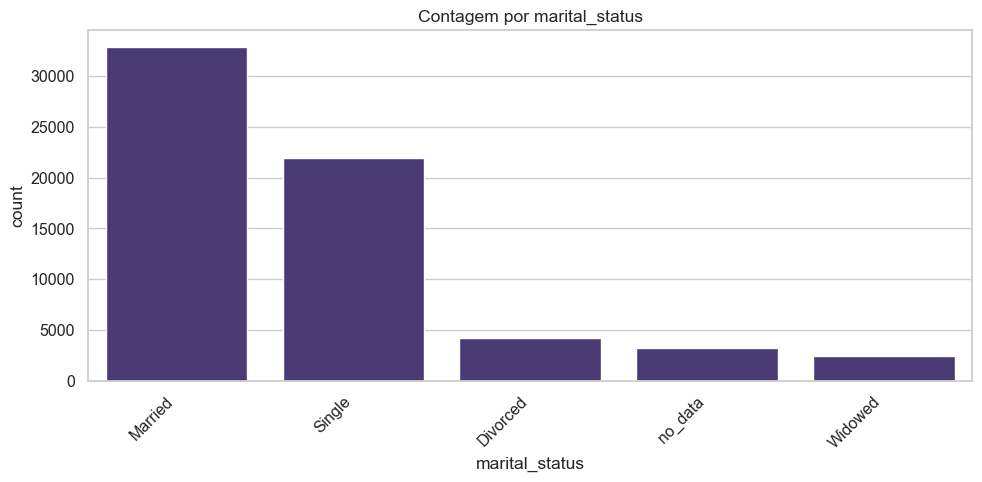

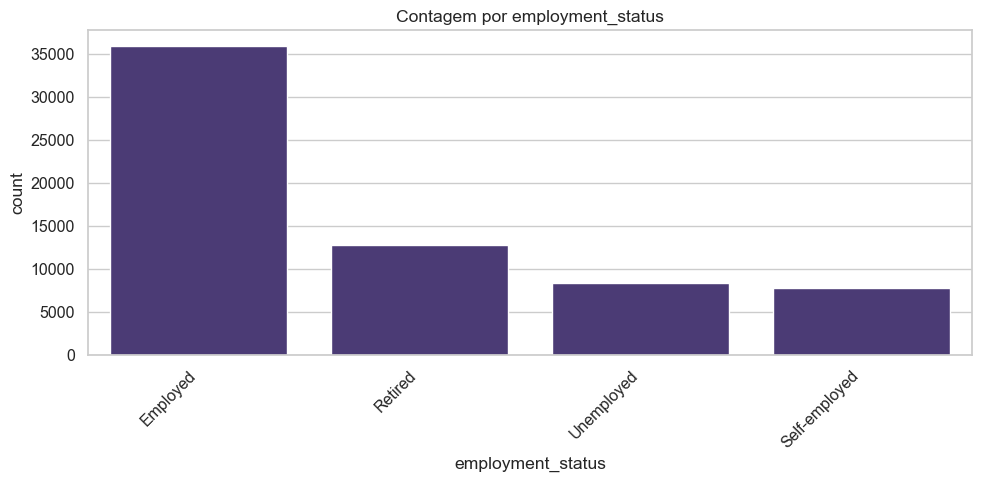

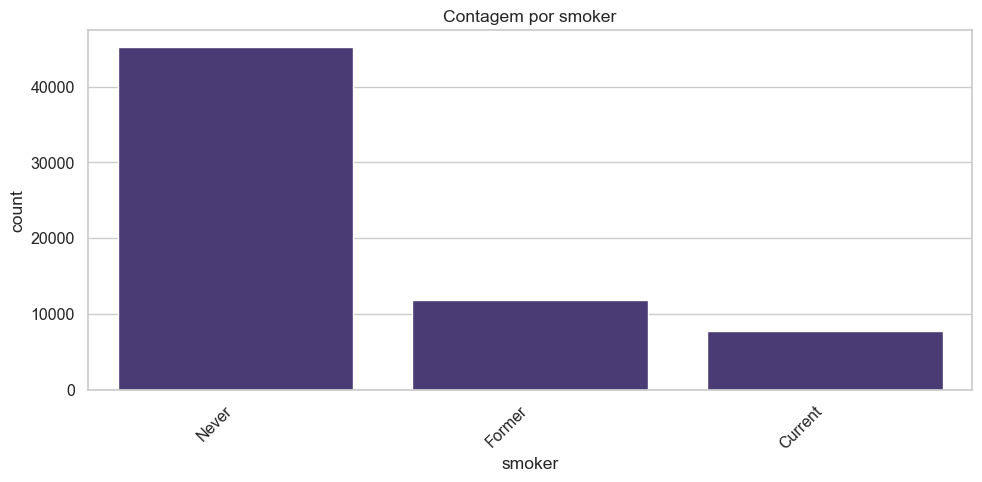

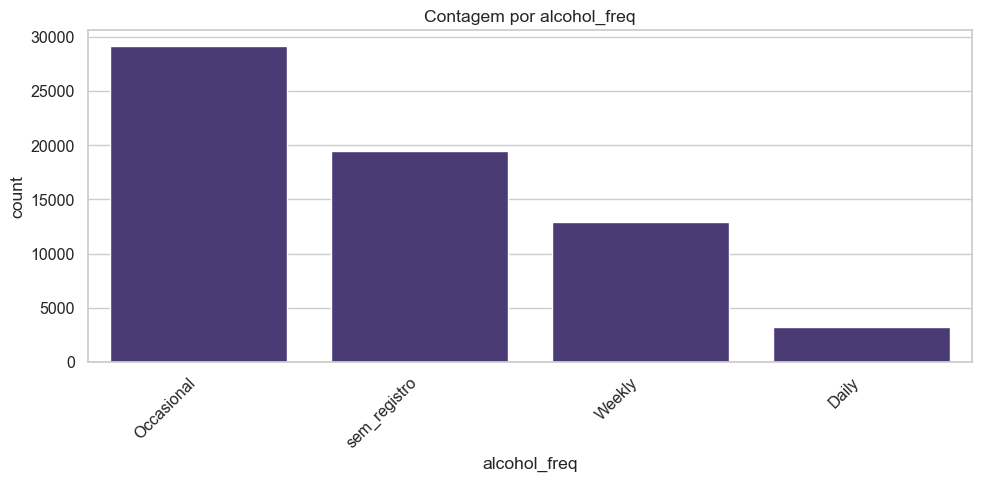

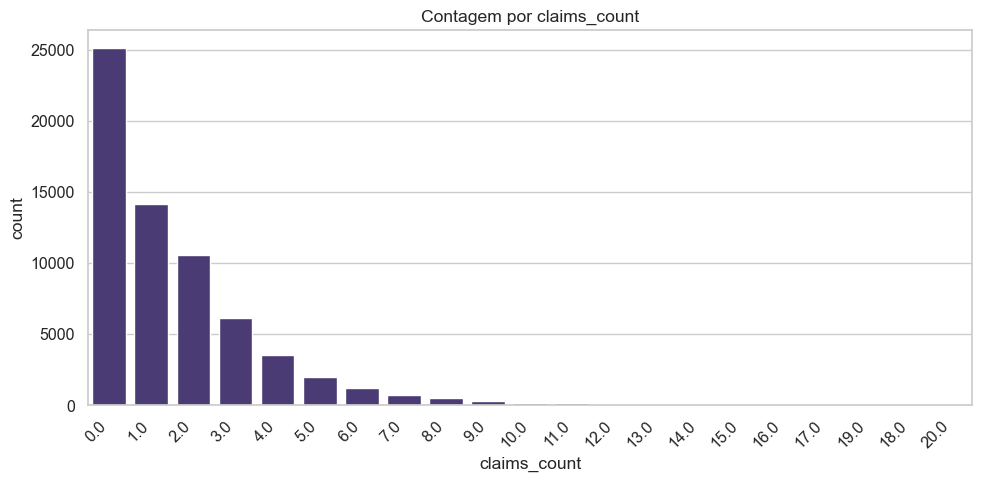

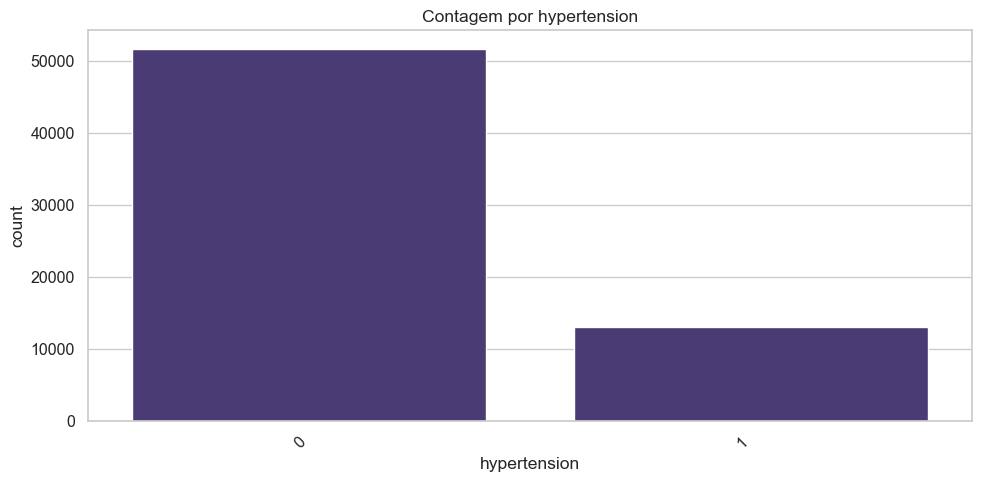

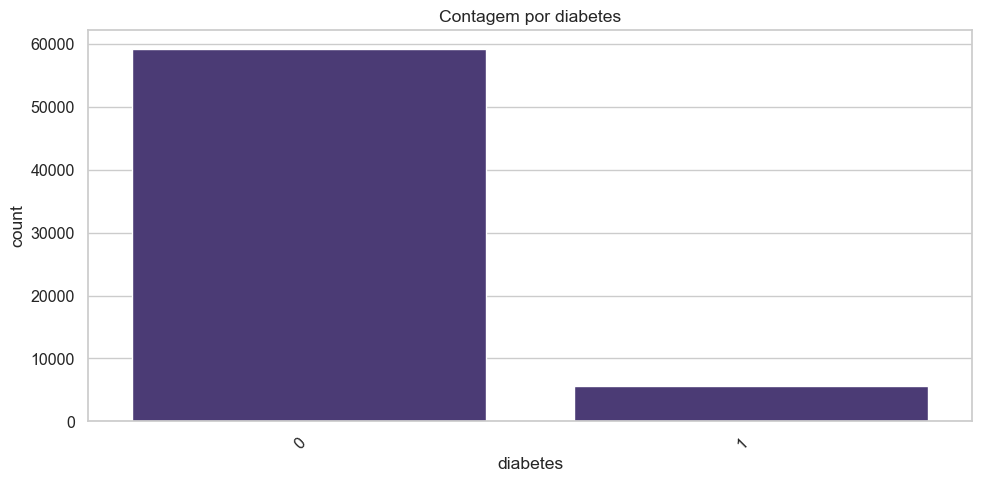

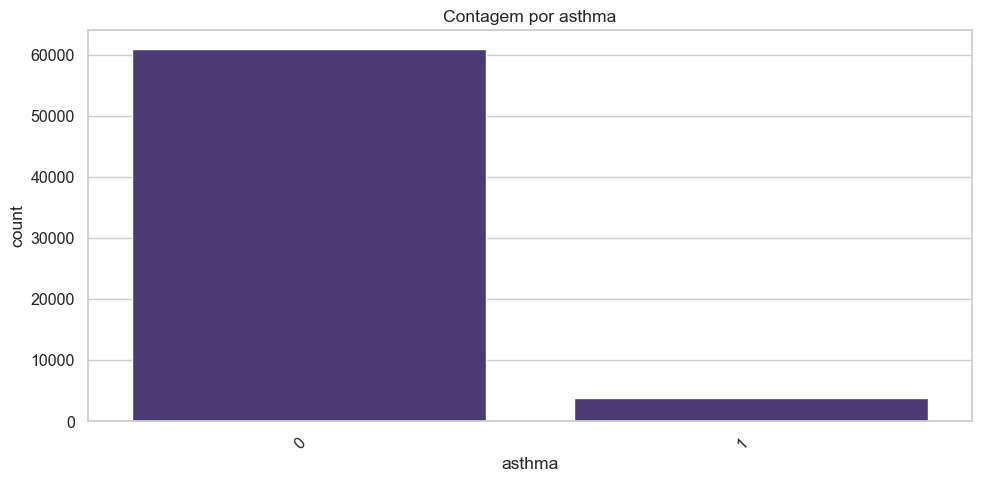

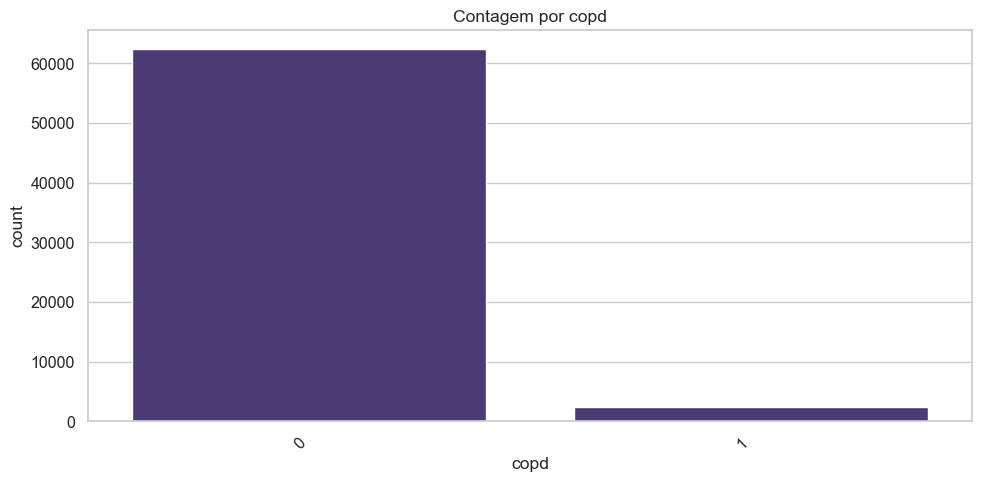

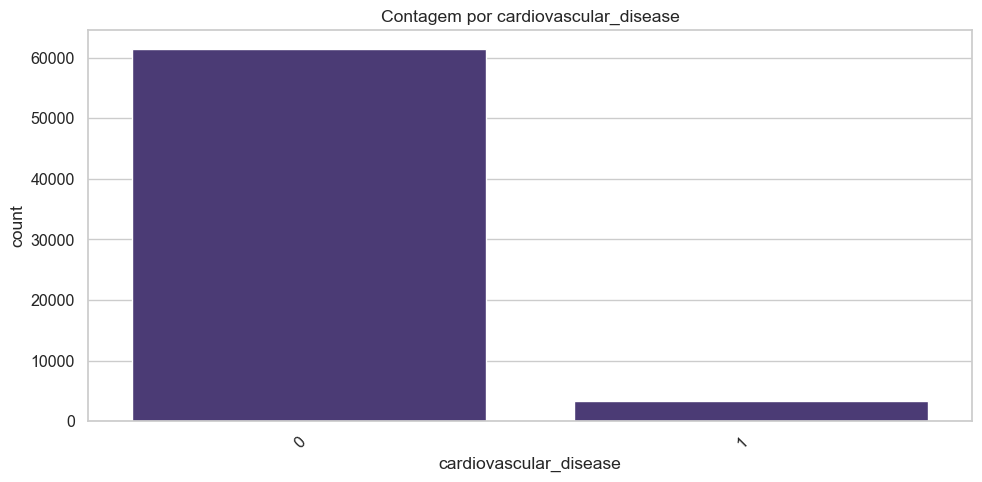

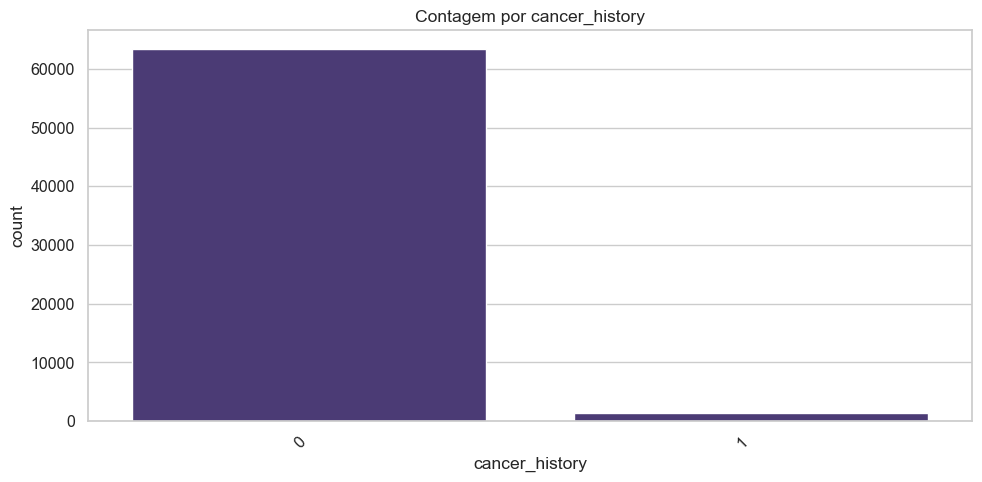

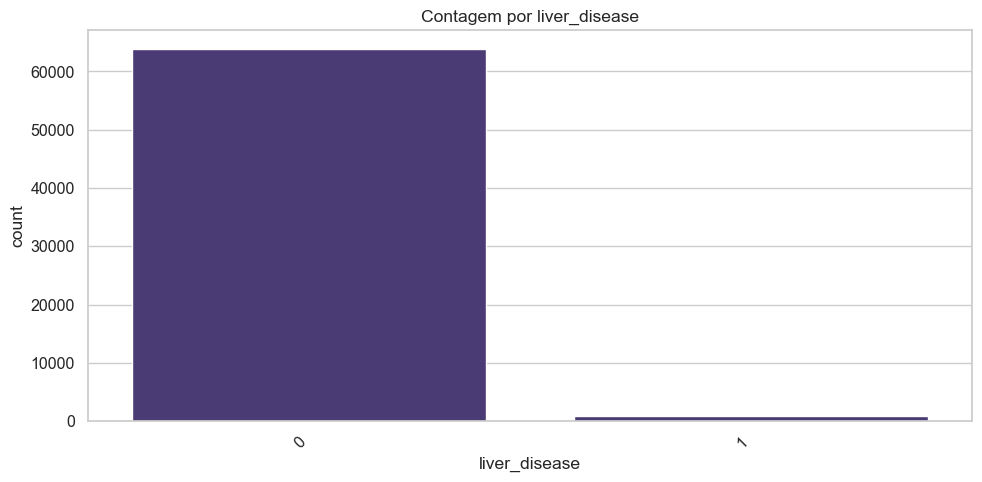

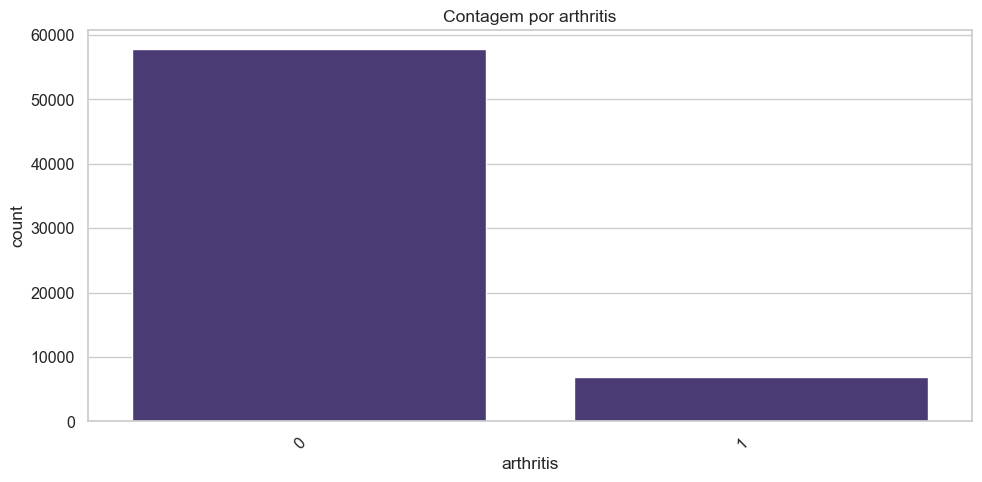

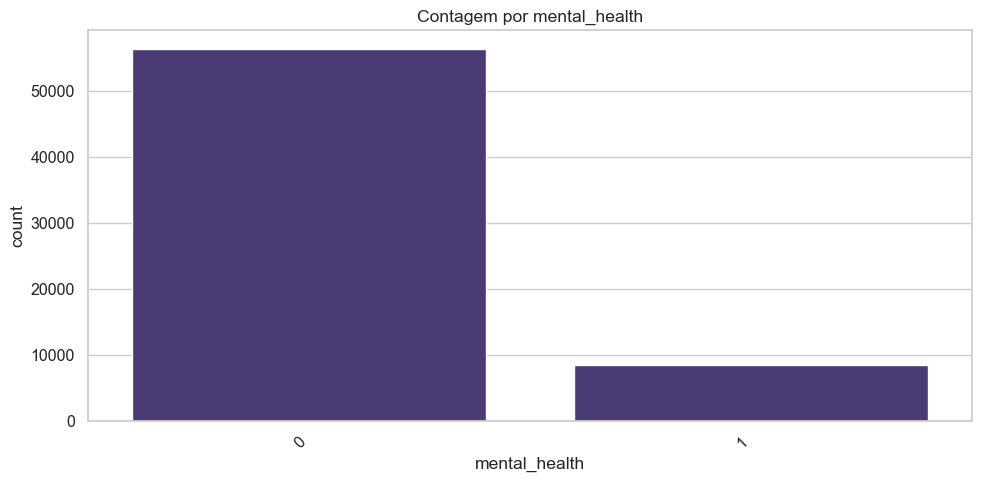

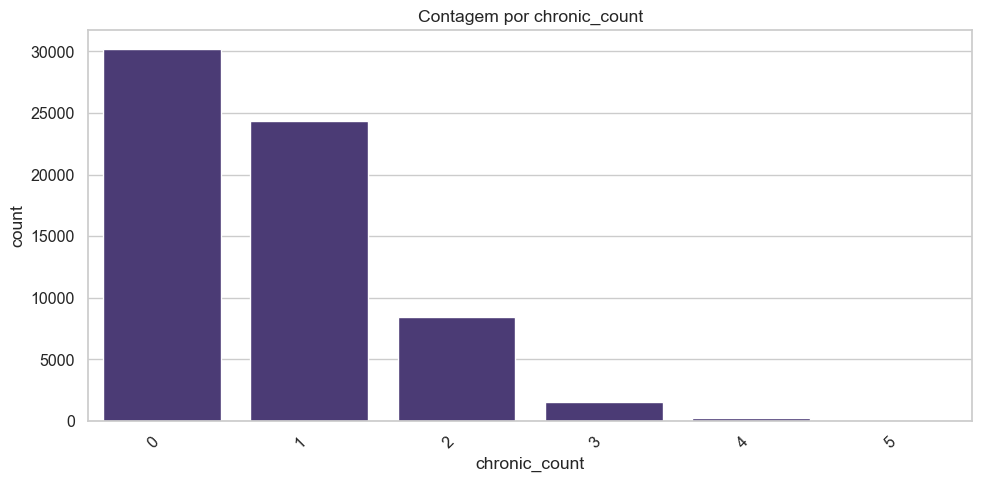

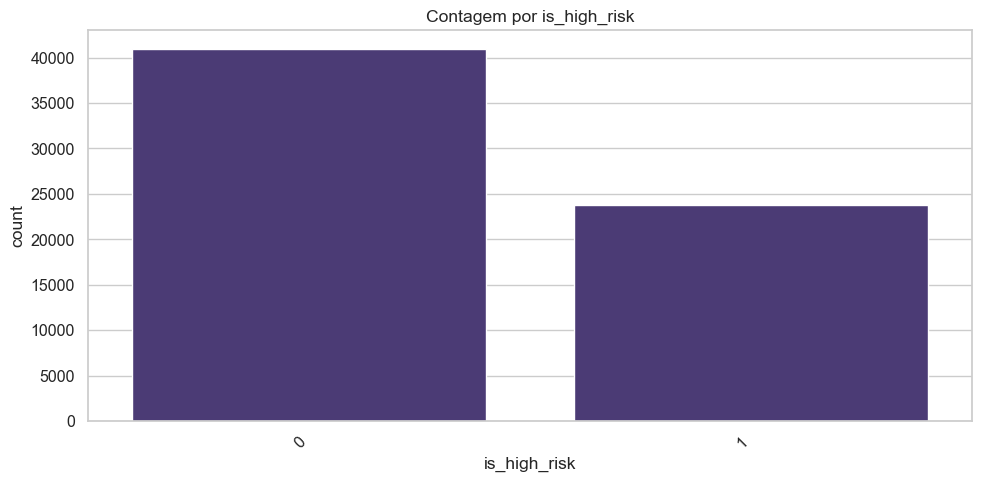

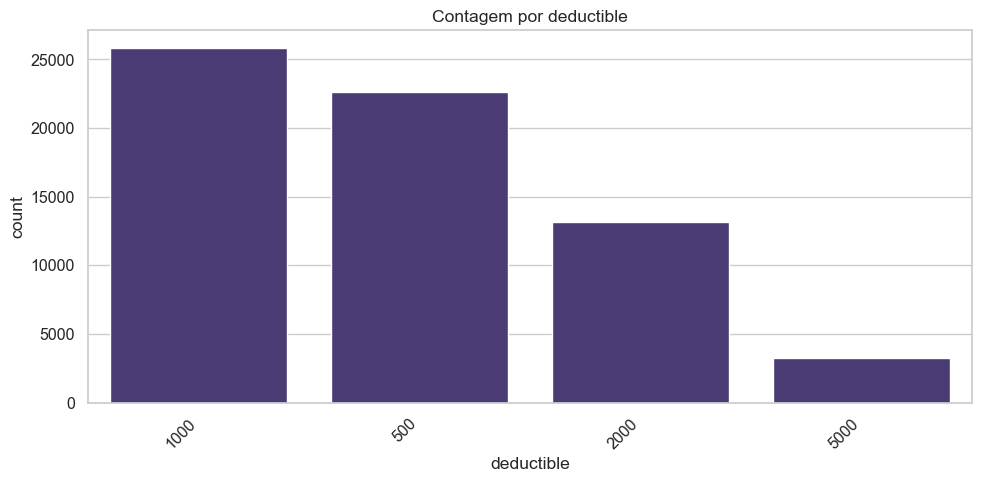

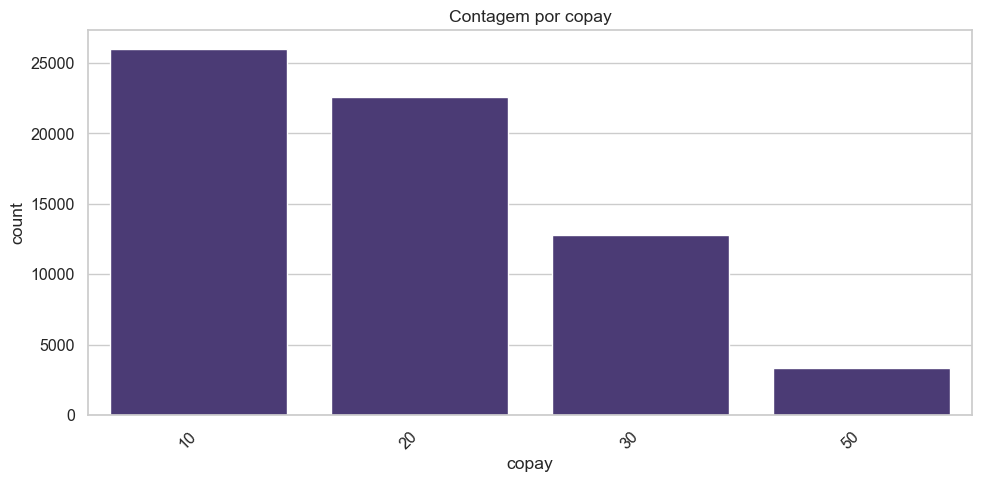

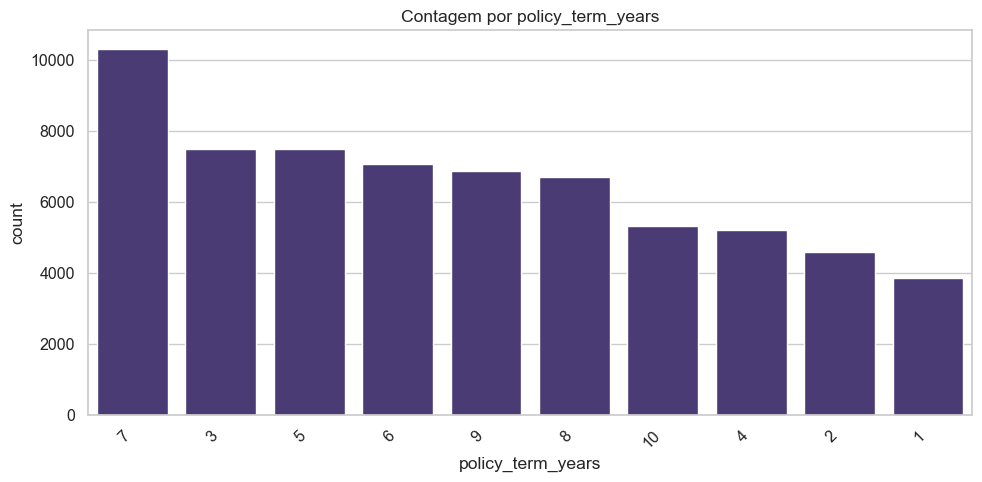

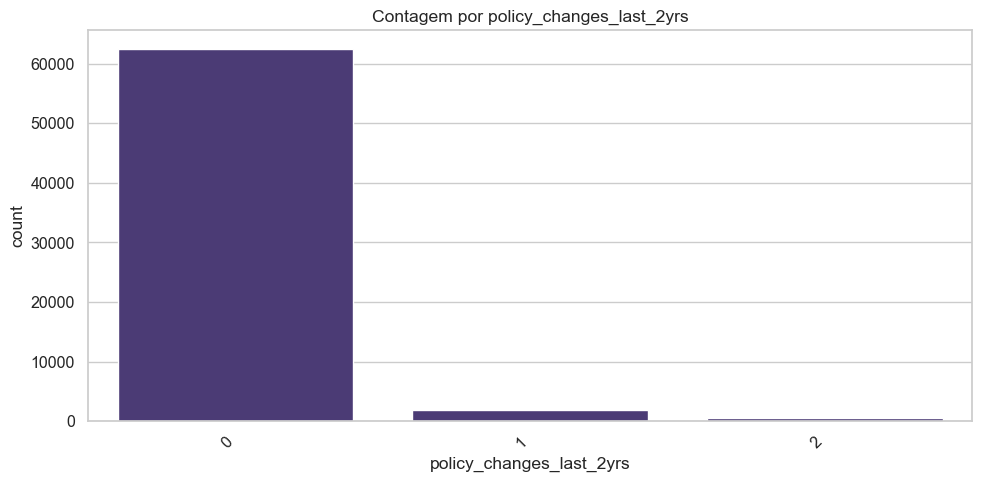

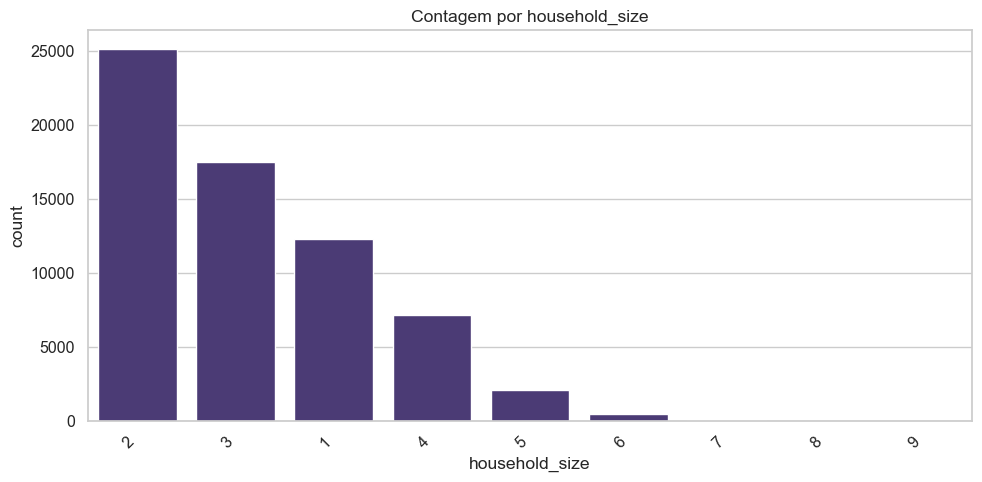

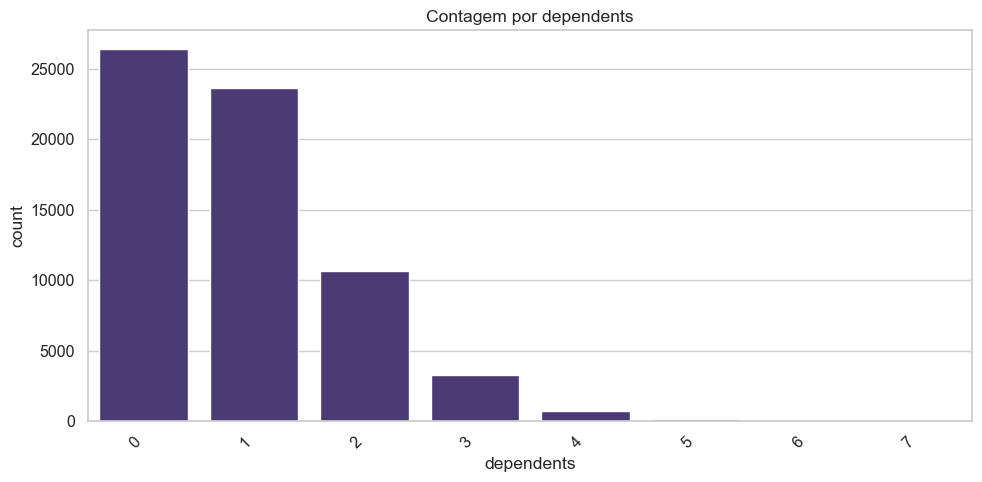

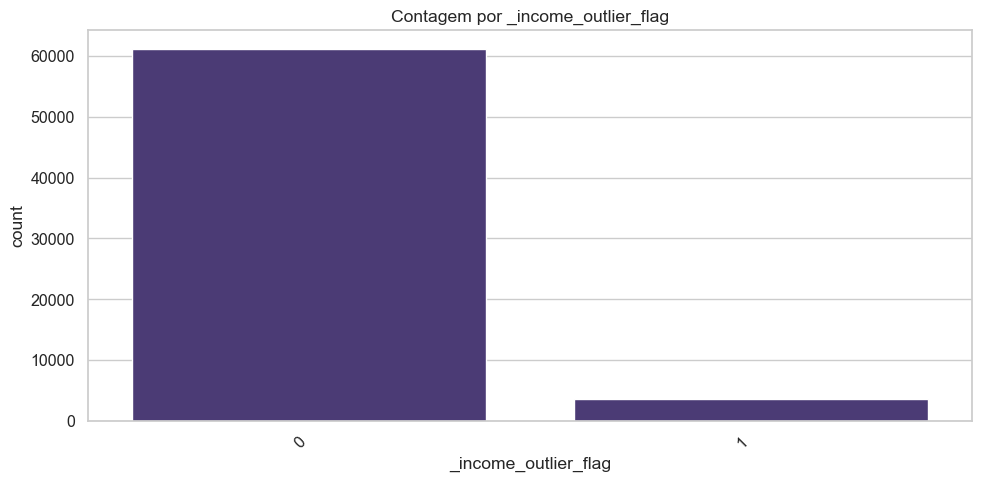

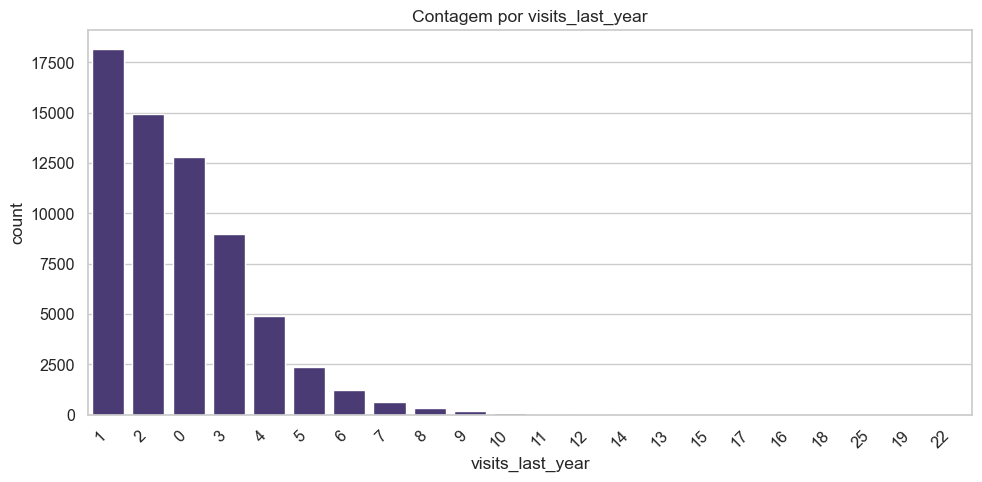

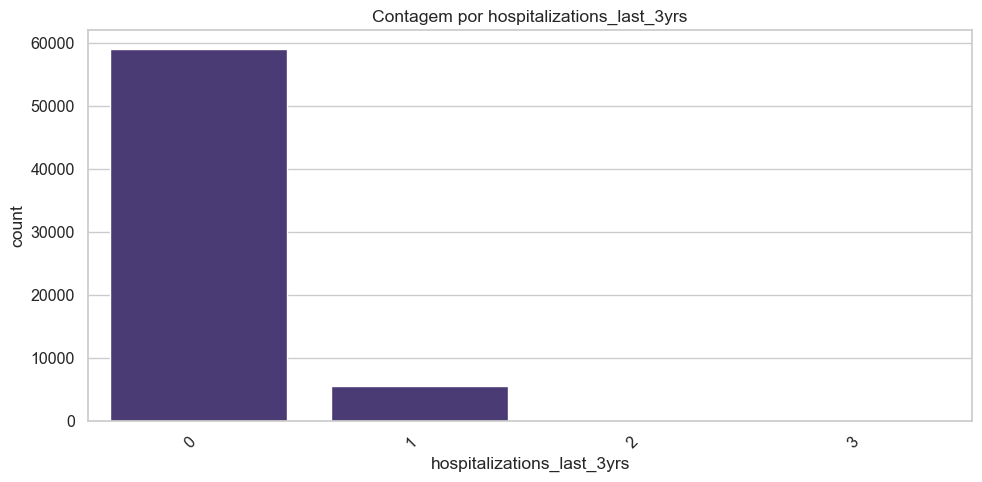

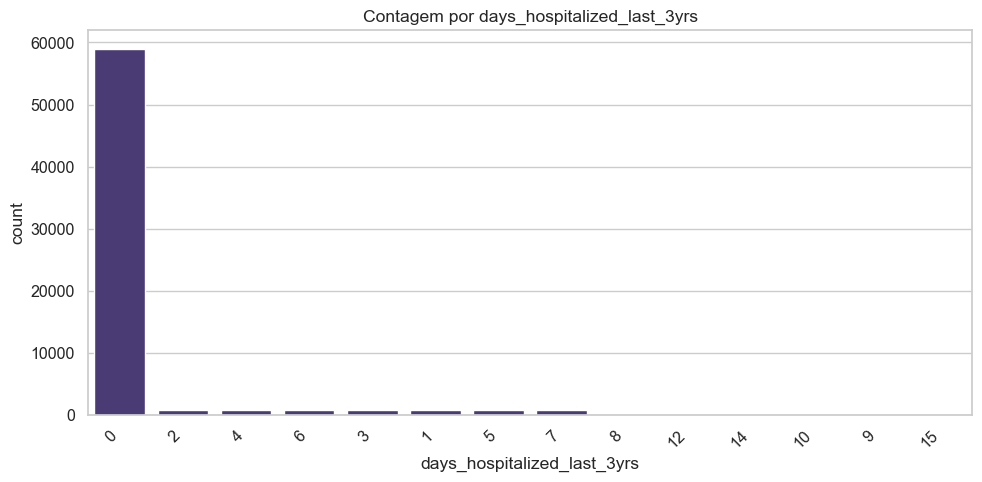

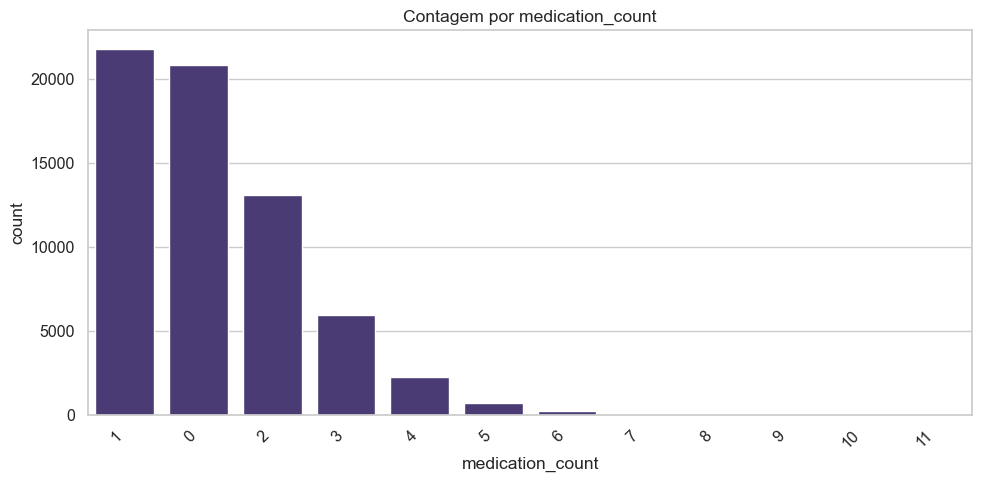

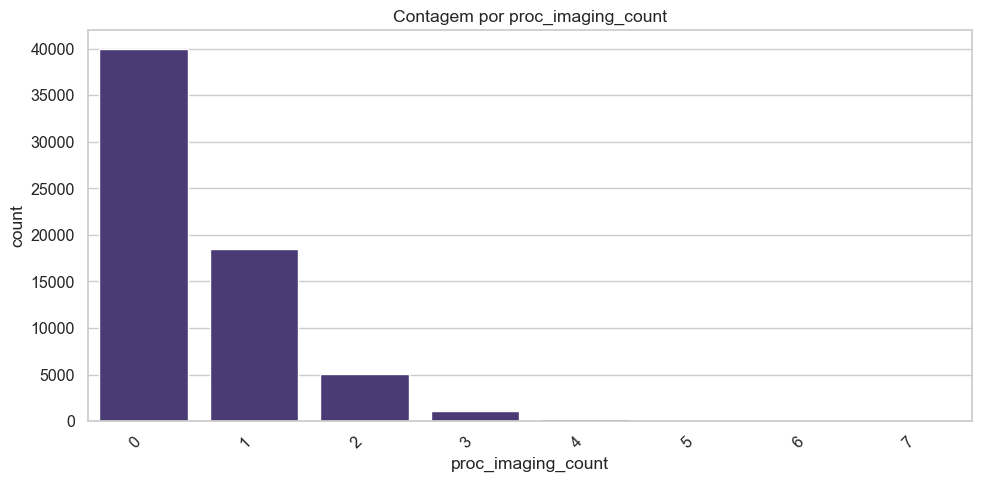

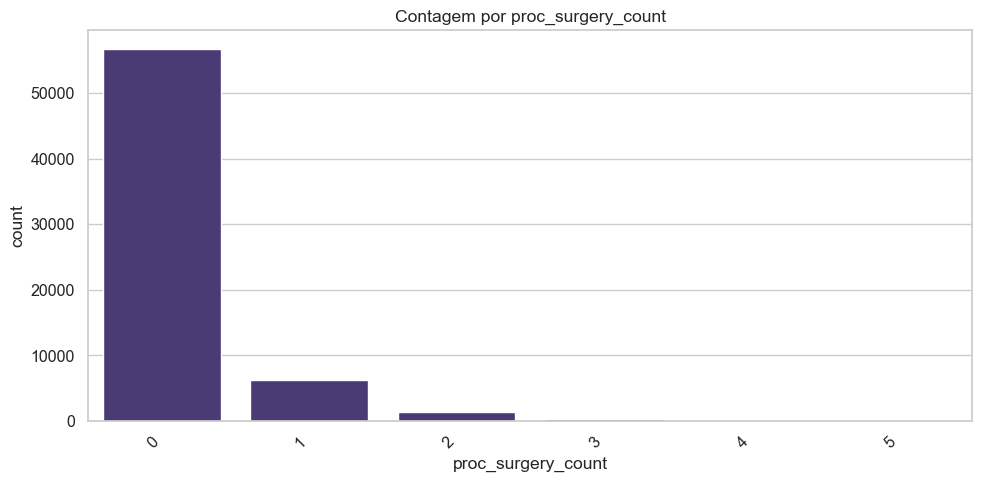

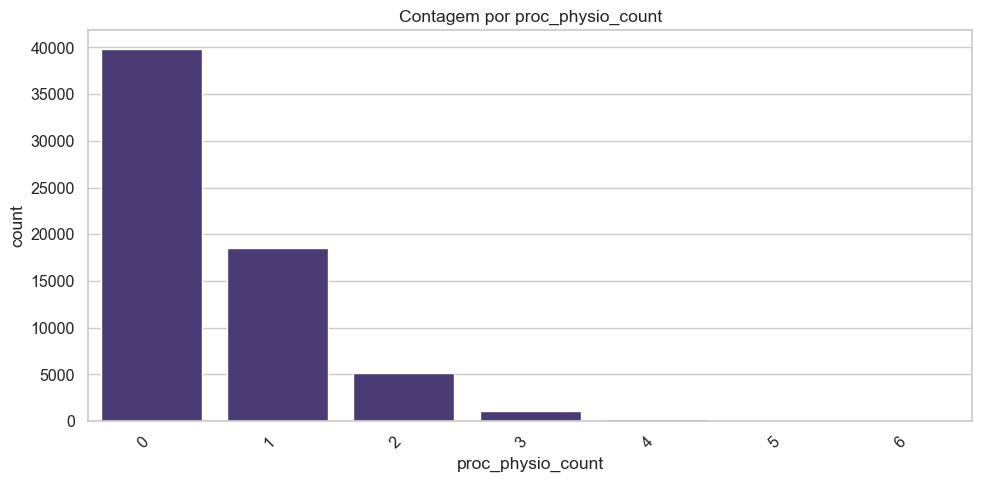

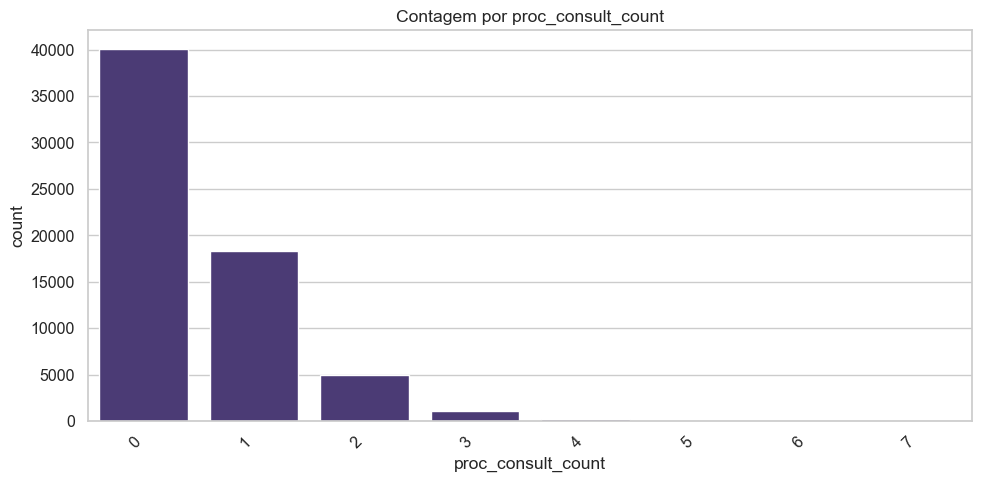

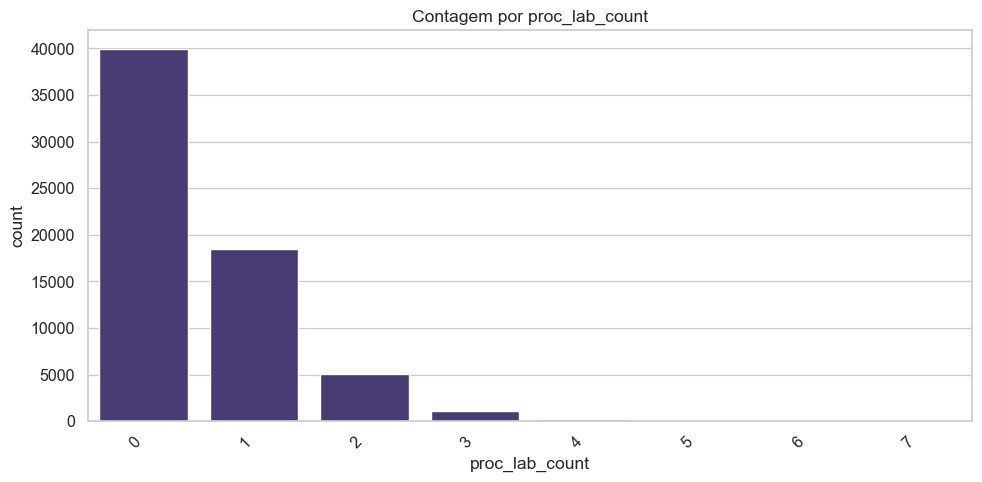

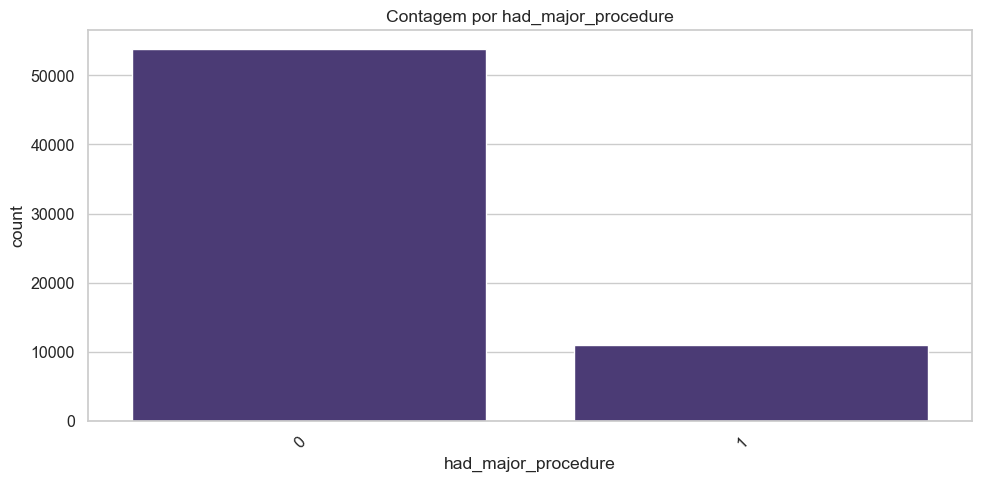

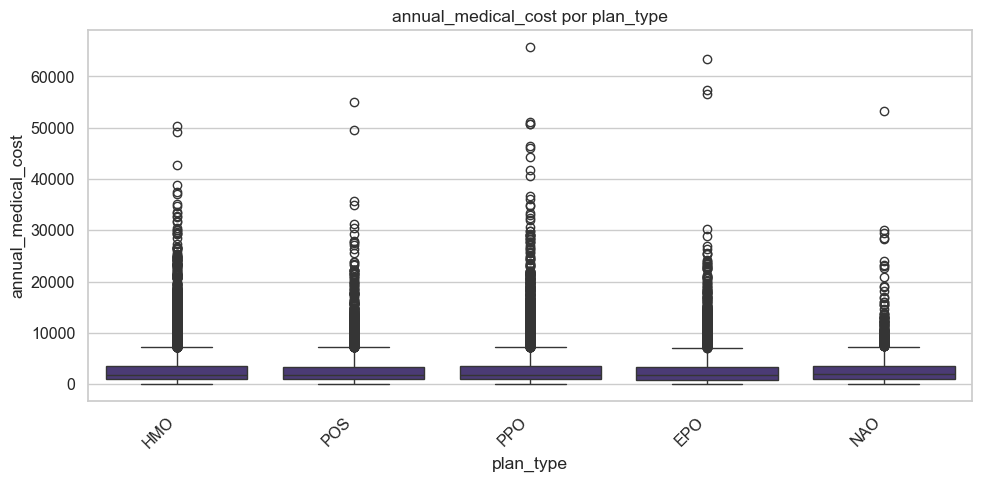

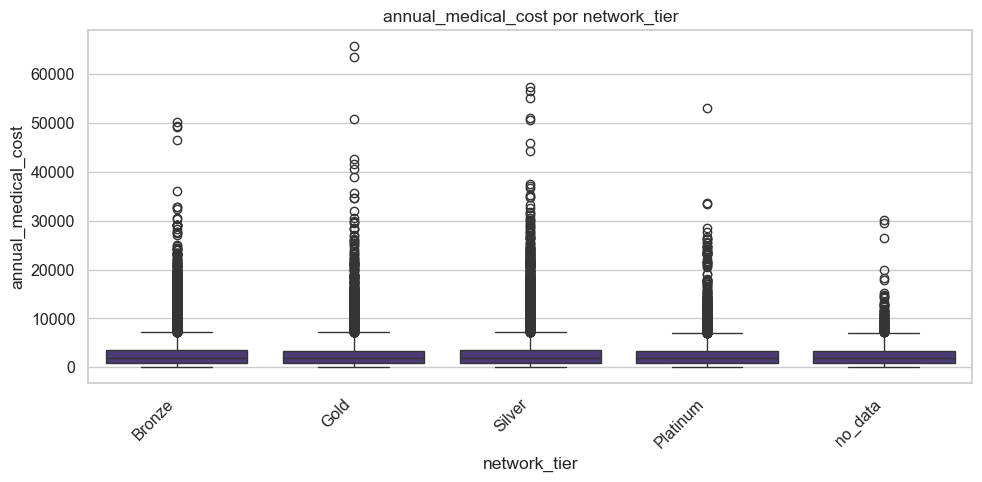

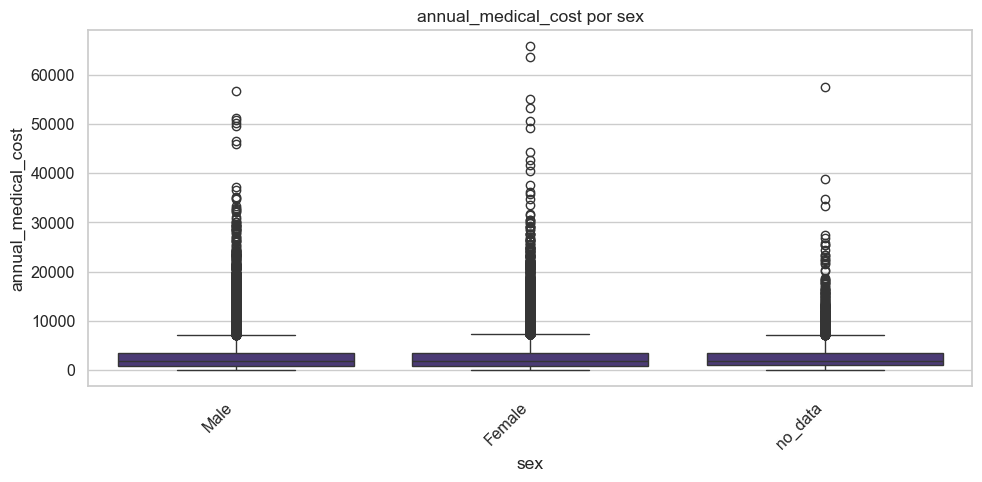

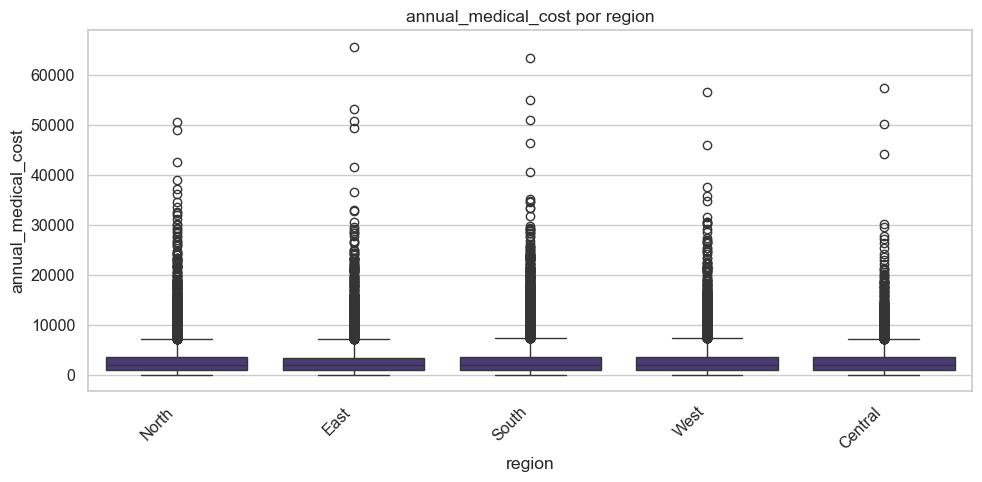

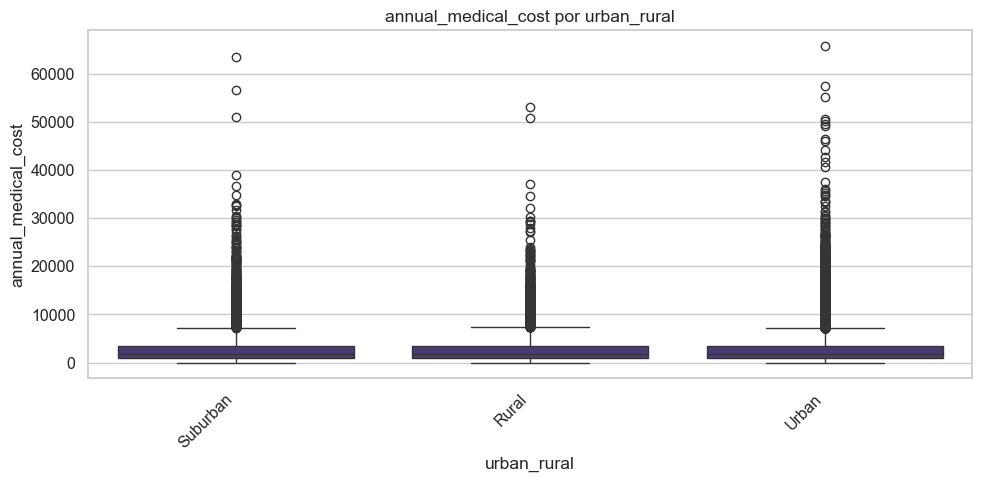

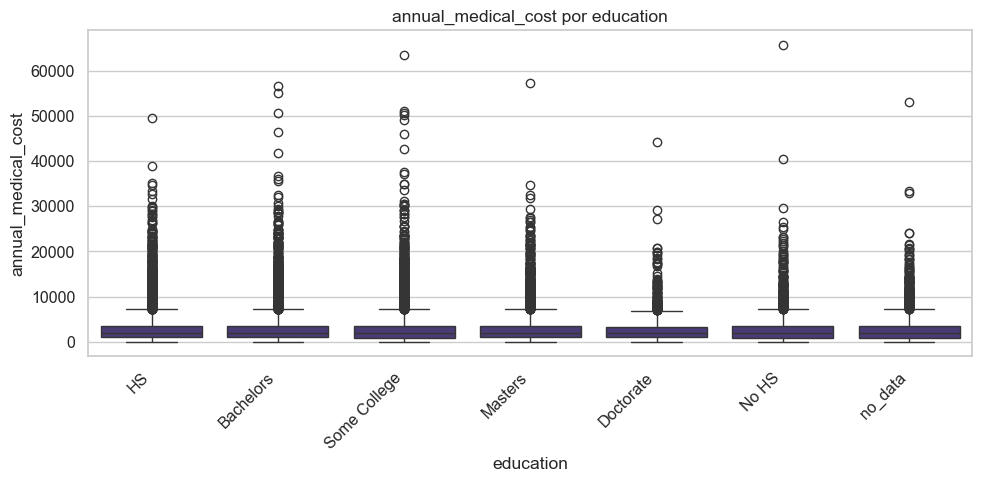

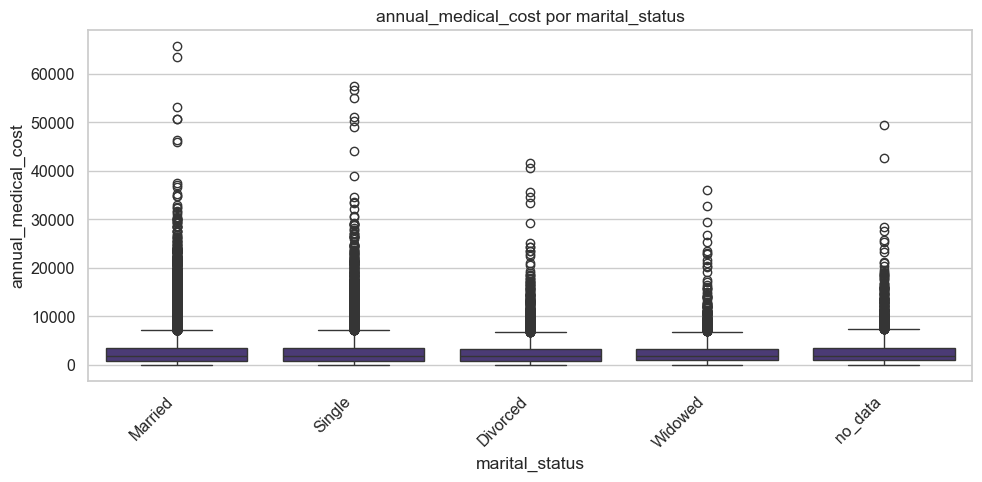

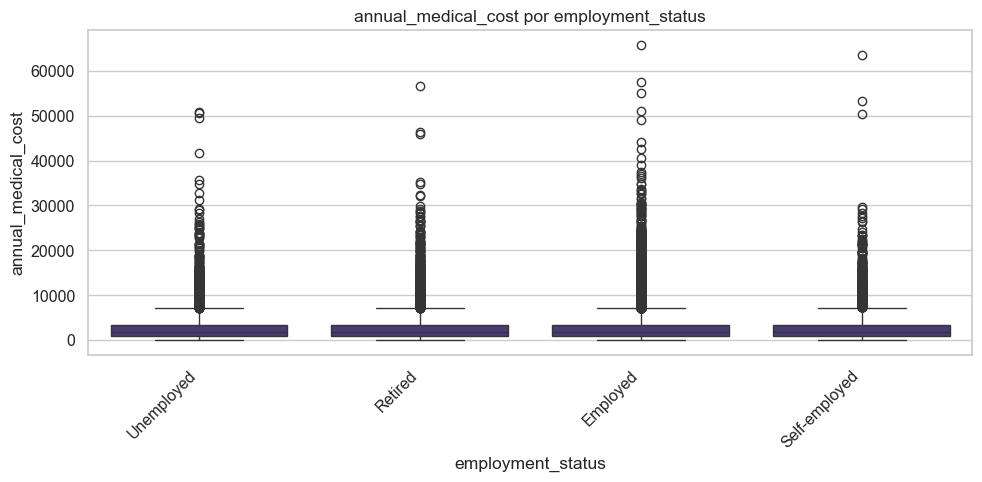

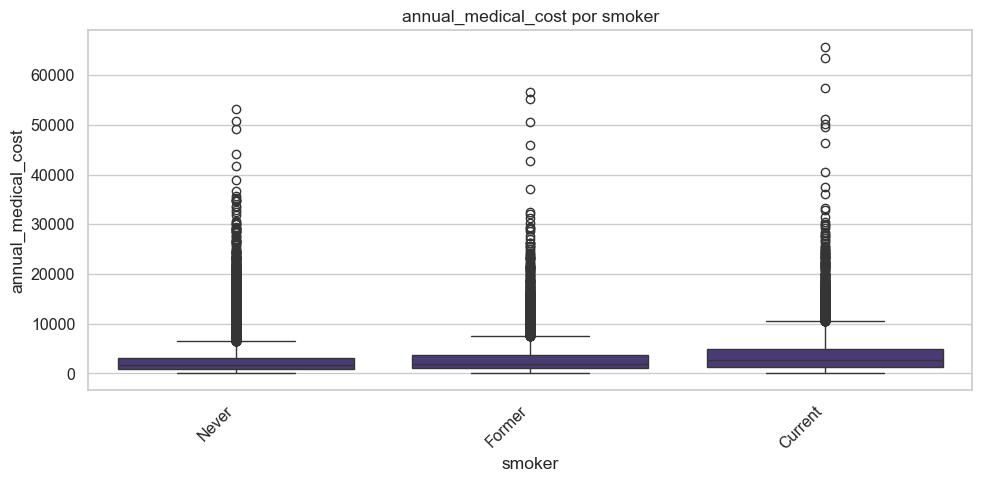

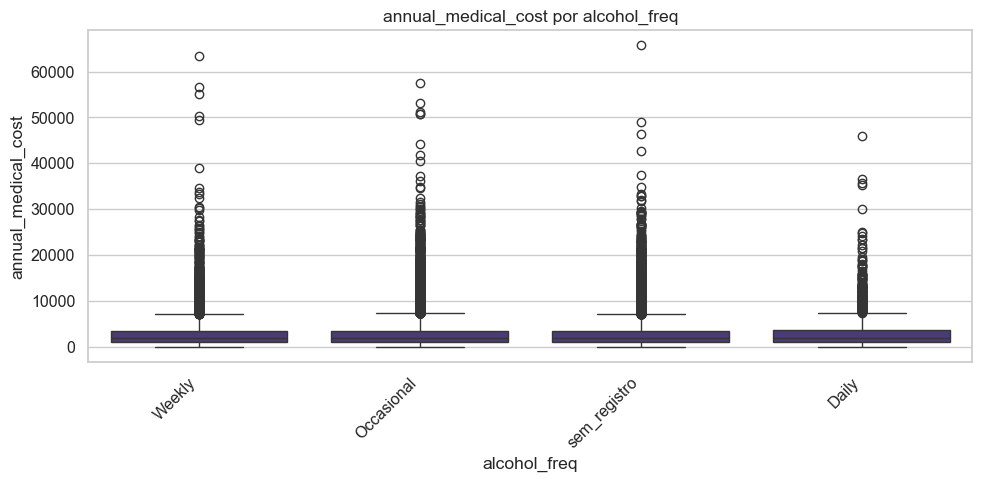

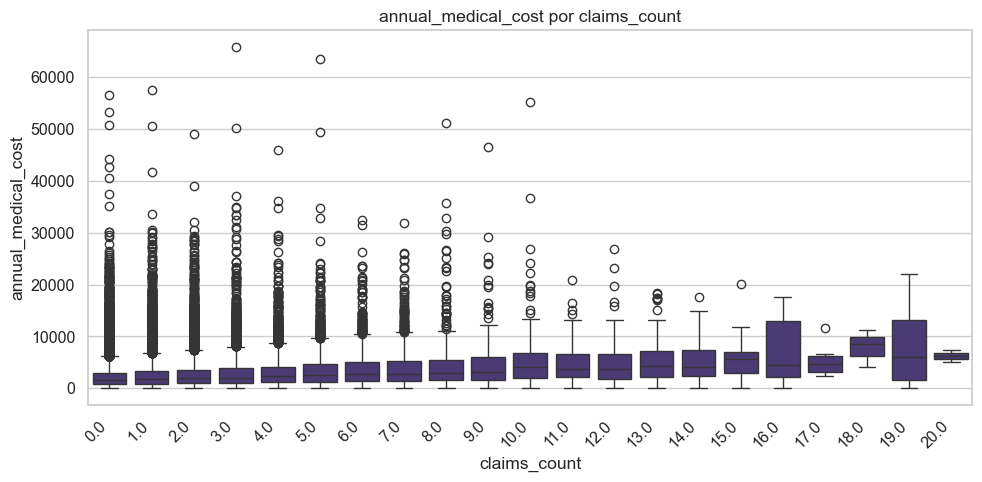

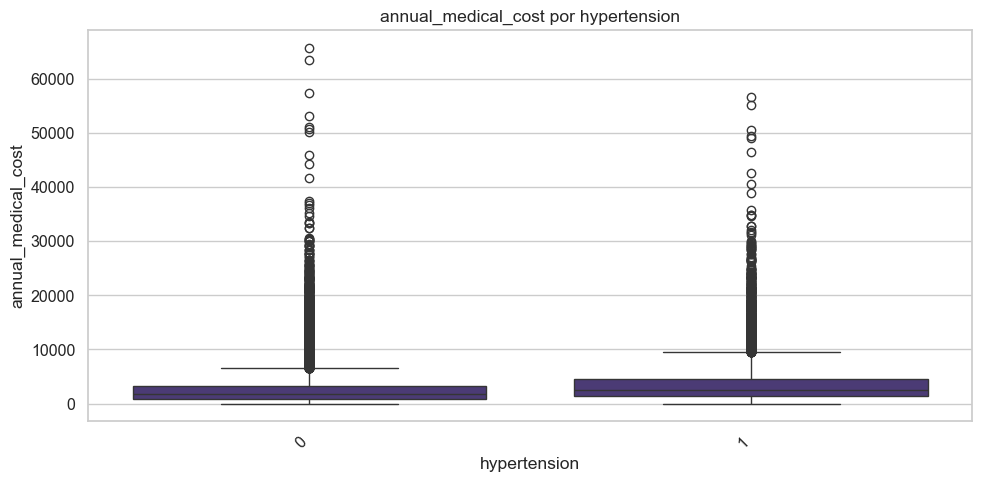

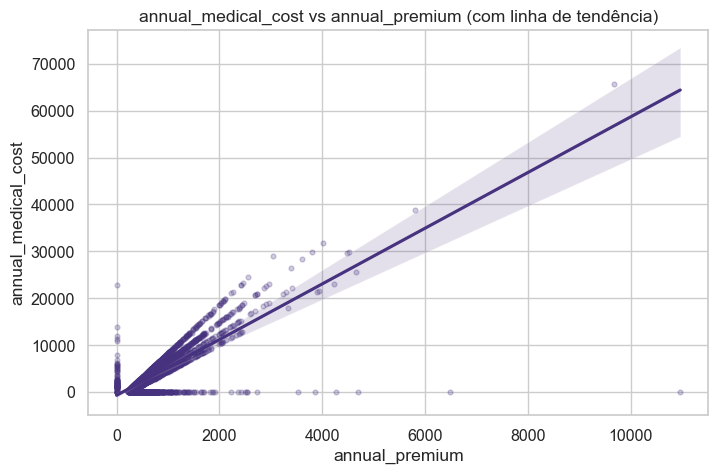

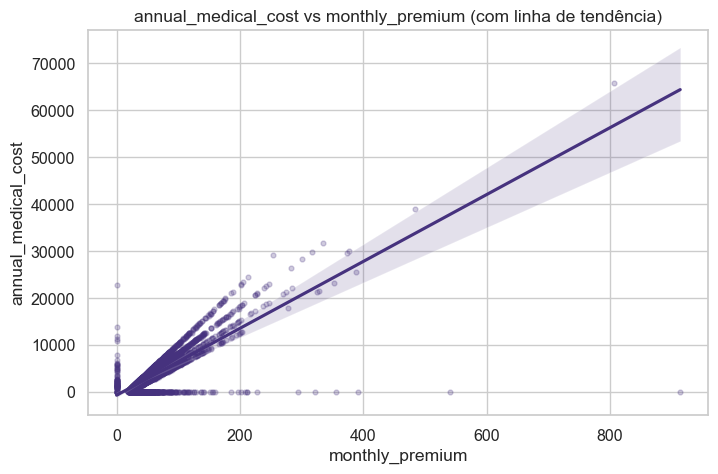

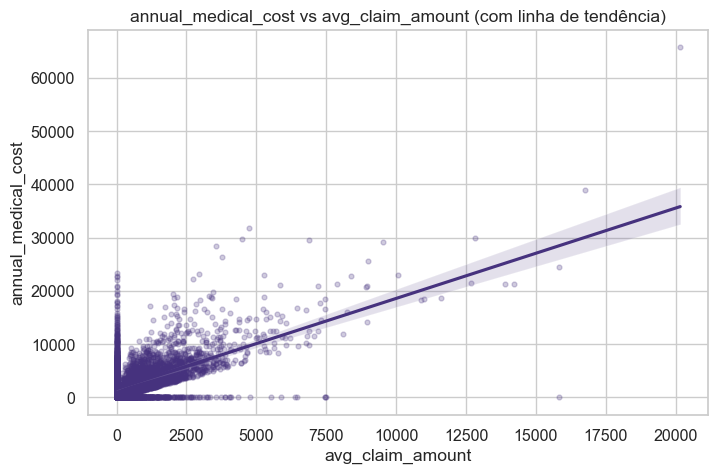

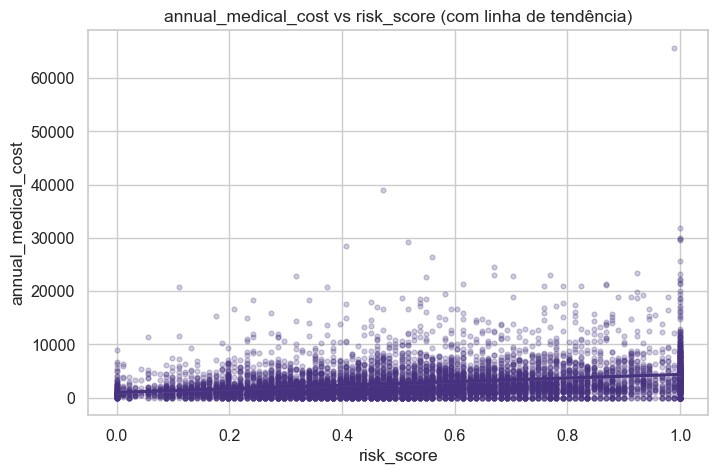

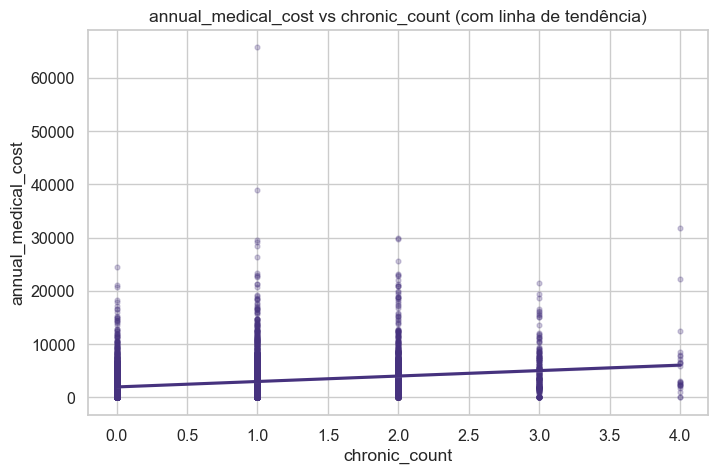

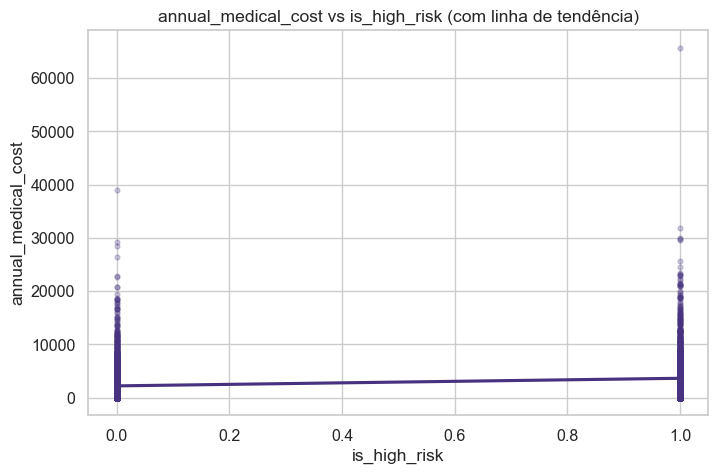

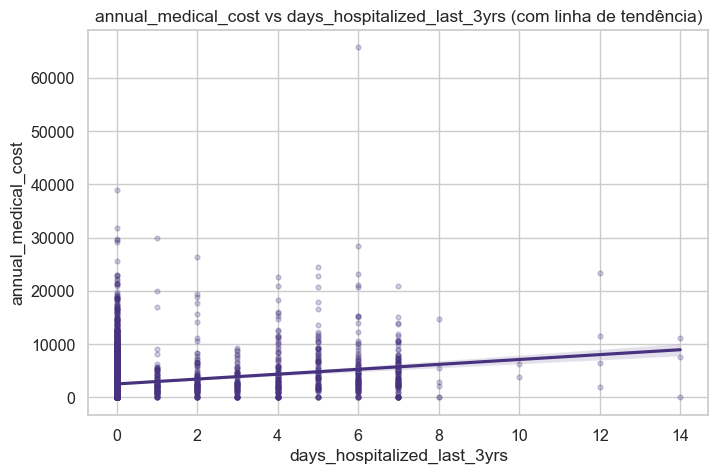

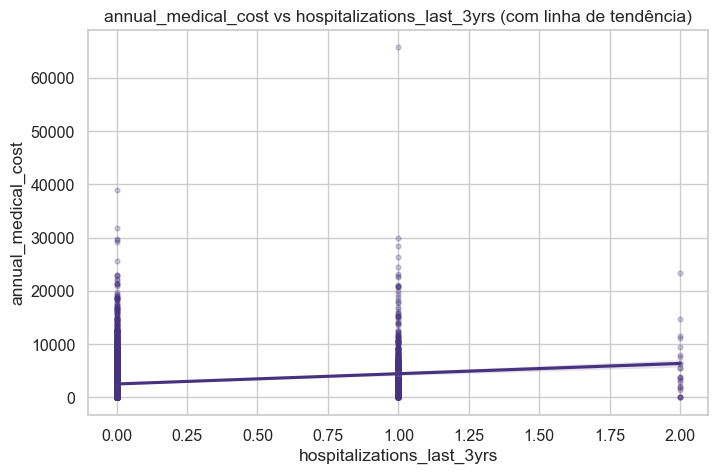

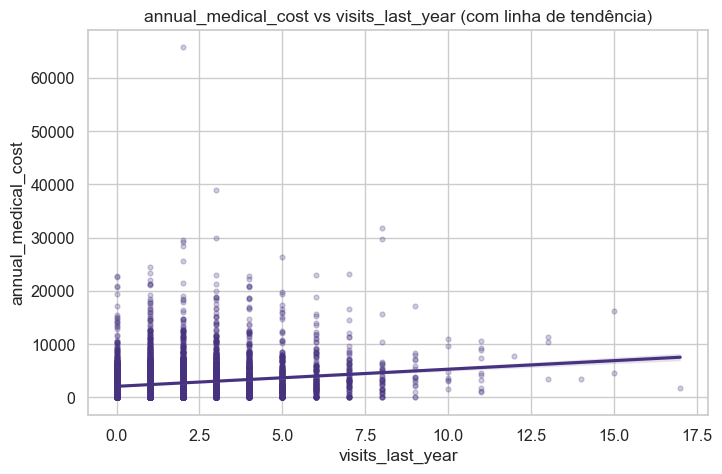

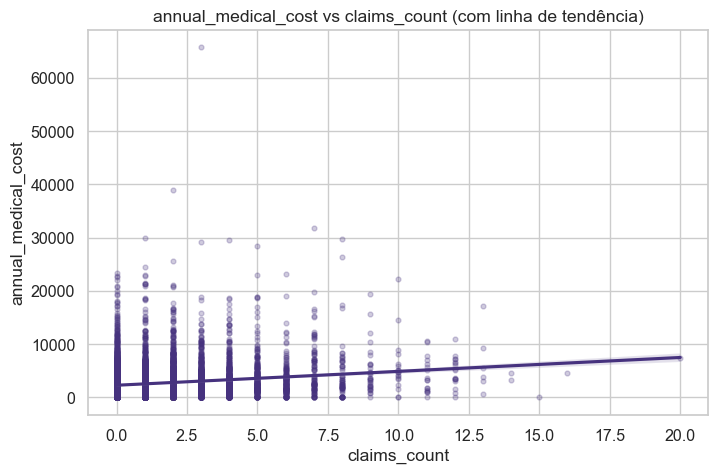

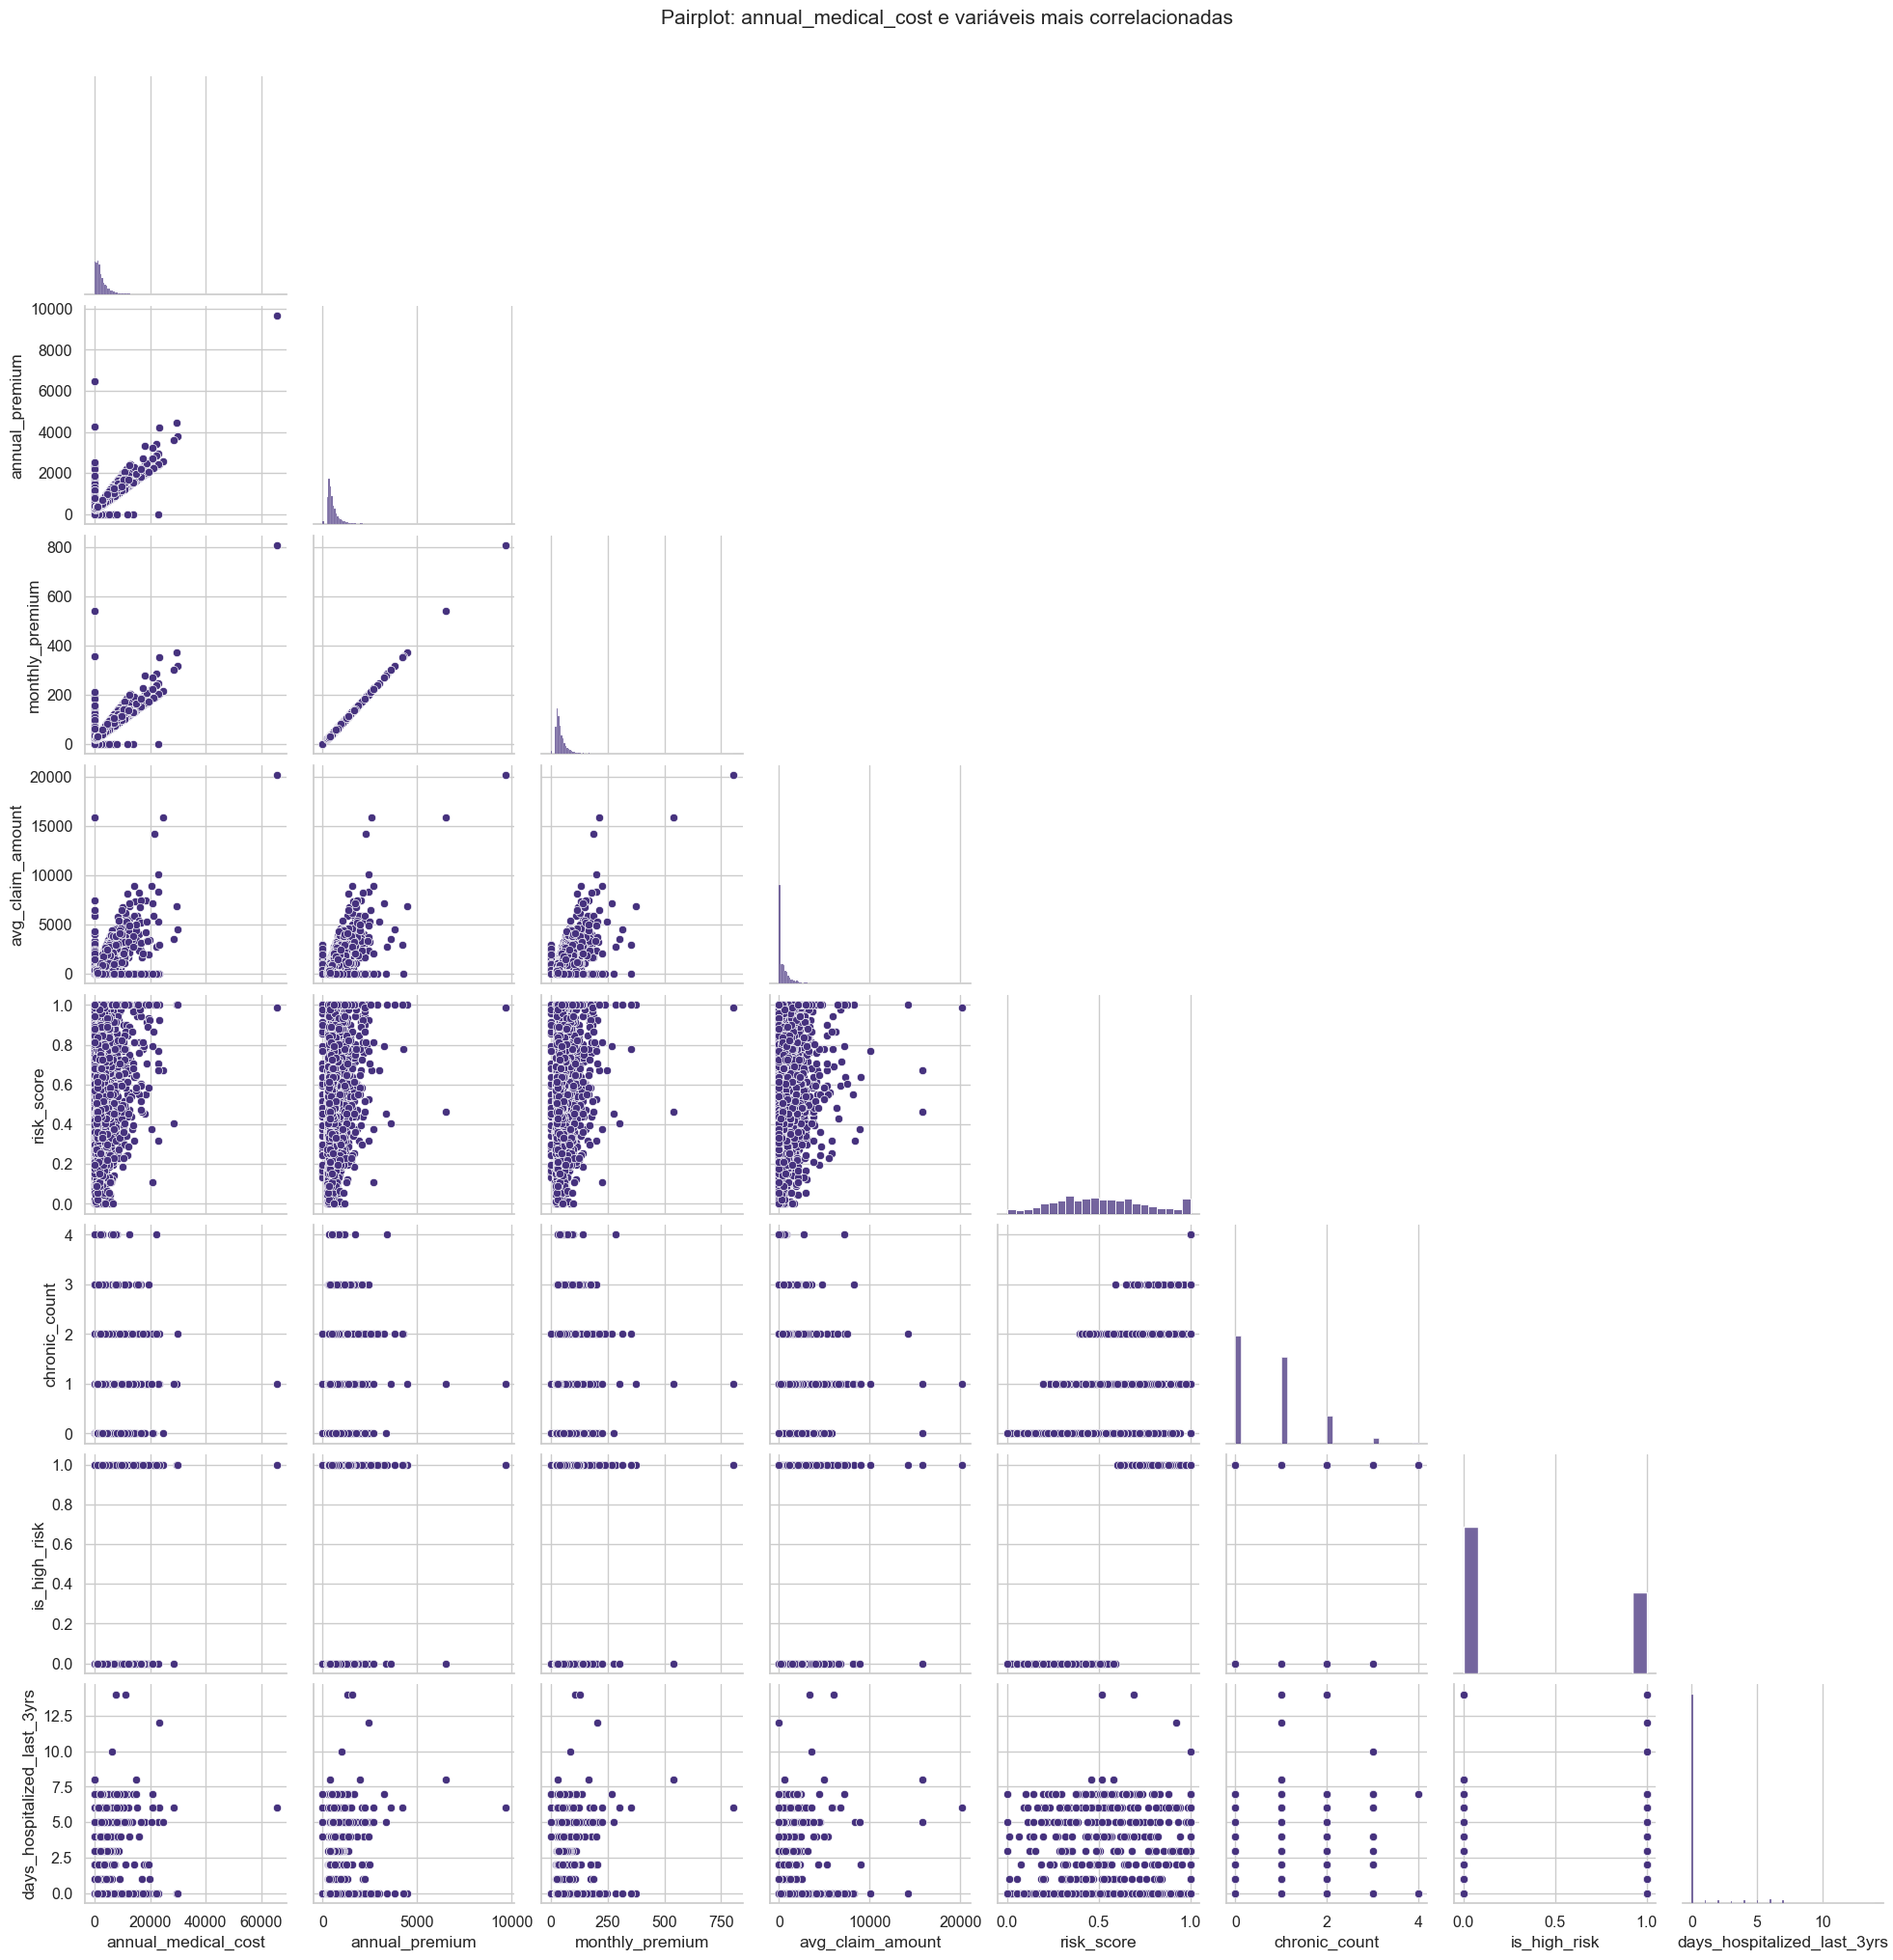

In [32]:

# === 12) Gráficos originais ===
plot_distributions(df, [c for c in num_cols if c != target])
plot_countplots(df, cat_cols, limit_each=40)
plot_boxplots_cat_target(df, cat_cols, target, max_plots=MAX_BOXPLOTS, limit_each=40)
if target:
    plot_scatter_with_target(df, [c for c in num_cols if c != target], target, max_plots=MAX_SCATTERS, sample_n=SAMPLE_FOR_SCATTER)
    plot_pairplot_top(df, target, corr_full, max_vars=MAX_PAIRPLOT_VARS)


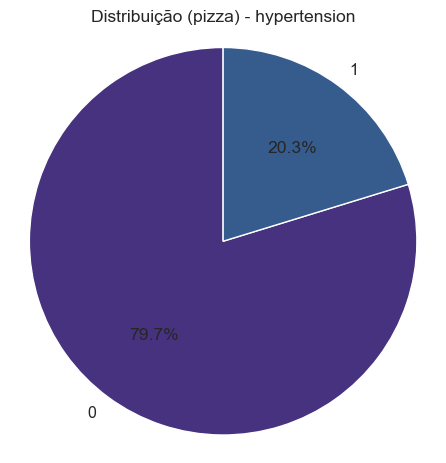

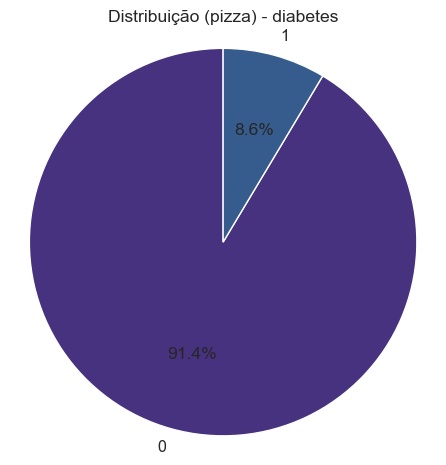

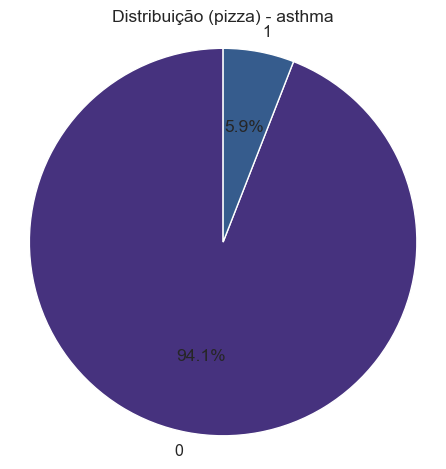

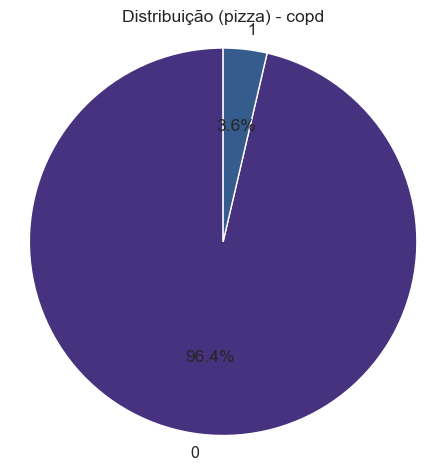

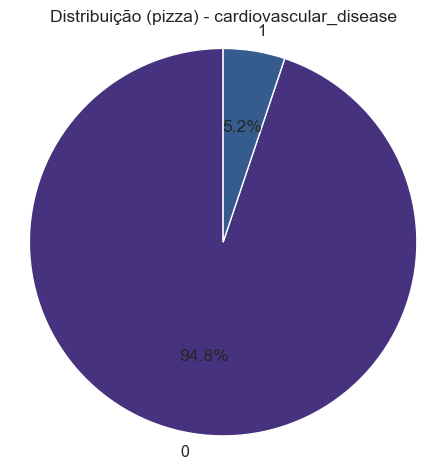

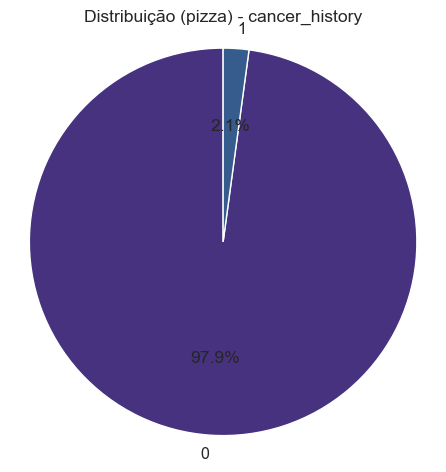

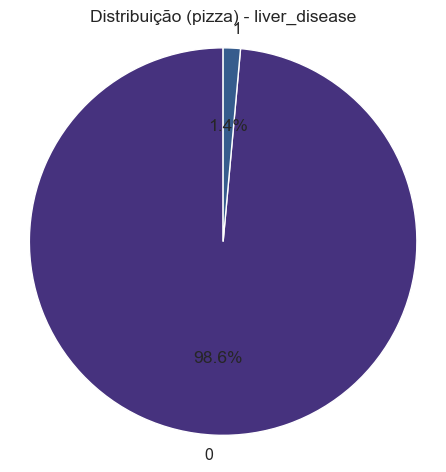

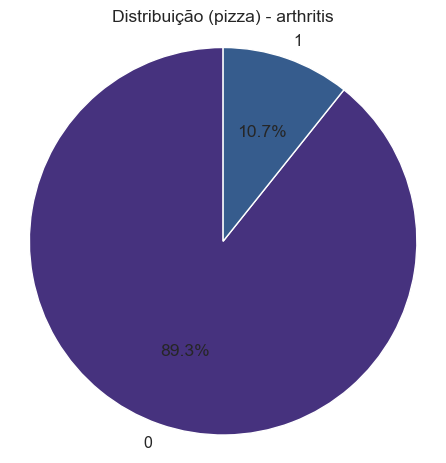

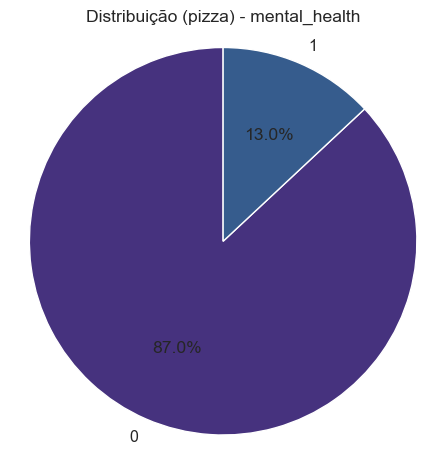

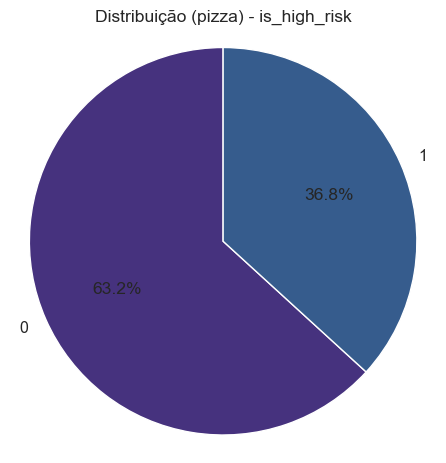

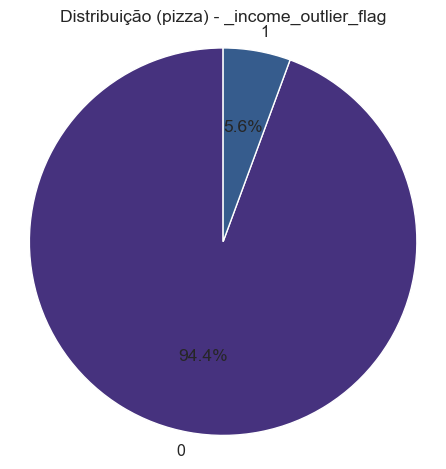

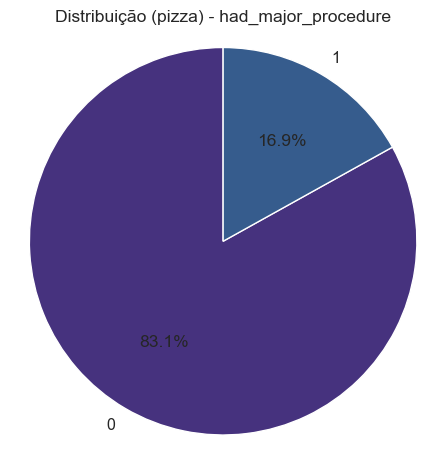

In [33]:

# === 13) Pizzas para todas as binárias ===
if bin_cols:
    plot_pies_for_binary_columns(df, bin_cols, max_pies=MAX_PIES_BINARIES)
else:
    print("[info] Nenhuma coluna binária detectada.")


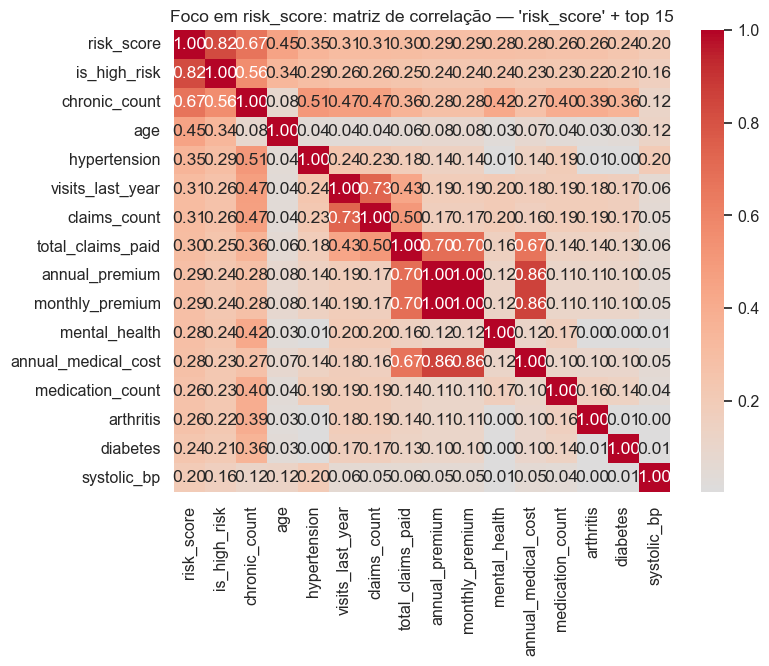

variavel  correlacao  abs_correlacao
0          is_high_risk    0.821463        0.821463
1         chronic_count    0.665451        0.665451
2                   age    0.447687        0.447687
3          hypertension    0.346745        0.346745
4      visits_last_year    0.312393        0.312393
5          claims_count    0.306973        0.306973
6     total_claims_paid    0.299384        0.299384
7        annual_premium    0.285933        0.285933
8       monthly_premium    0.285933        0.285933
9         mental_health    0.284354        0.284354
10  annual_medical_cost    0.276581        0.276581
11     medication_count    0.264131        0.264131
12            arthritis    0.262456        0.262456
13             diabetes    0.237133        0.237133
14          systolic_bp    0.198918        0.198918

[ok] top_corr_with_risk_score.csv salvo.


In [34]:

# === 14) Matriz + Tabela focadas em risk_score ===
tbl_risk, _ = plot_corr_matrix_anchor(df, "risk_score", topn=TOPN_RISK, title_prefix="Foco em risk_score")
if not tbl_risk.empty:
    display(tbl_risk)
    tbl_risk.to_csv("top_corr_with_risk_score.csv", index=False)
    print("[ok] top_corr_with_risk_score.csv salvo.")


variavel  correlacao  abs_correlacao
22           risk_score    0.821463        0.821463
17        chronic_count    0.562213        0.562213
28                  age    0.340836        0.340836
7          hypertension    0.292600        0.292600
34     visits_last_year    0.264740        0.264740
4          claims_count    0.261923        0.261923
6     total_claims_paid    0.249752        0.249752
16        mental_health    0.242124        0.242124
2        annual_premium    0.235936        0.235936
3       monthly_premium    0.235935        0.235935
1   annual_medical_cost    0.227714        0.227714
37     medication_count    0.225493        0.225493
15            arthritis    0.223034        0.223034
8              diabetes    0.205583        0.205583
9                asthma    0.161976        0.161976

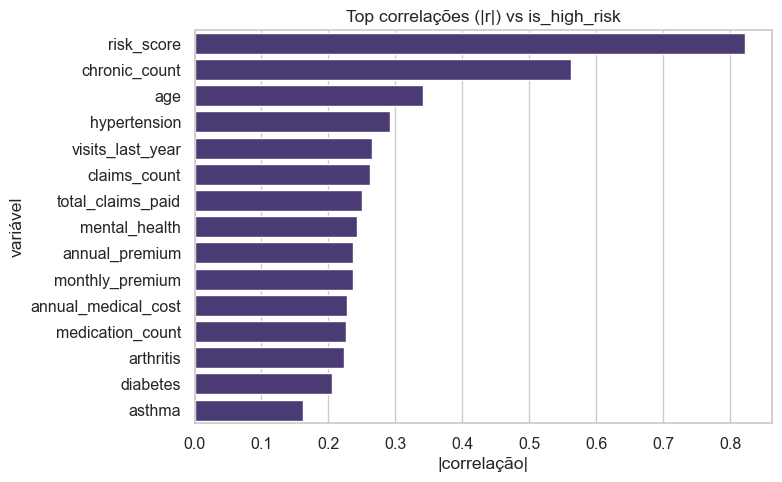

In [35]:

# === 15) Tabela vs is_high_risk (ponto-biserial) + gráfico ===
tbl_is_high = corr_with_binary_anchor(df, "is_high_risk", topn=TOPN_RISK)
if not tbl_is_high.empty:
    display(tbl_is_high)
    tbl_is_high.to_csv("top_corr_with_is_high_risk.csv", index=False)
    plt.figure(figsize=(8,5))
    sns.barplot(data=tbl_is_high, x="abs_correlacao", y="variavel")
    plt.title(tight_title("Top correlações (|r|) vs is_high_risk"))
    plt.xlabel("|correlação|"); plt.ylabel("variável")
    savefig_maybe("top_corr_is_high_risk")
    plt.tight_layout(); plt.show()


In [36]:

# === 16) Tabelas multivariáveis (annual_medical_cost × risk_score × categorias) ===
mv = multivar_tables(df, cost_col="annual_medical_cost", risk_col="risk_score")
for k, v in mv.items():
    print(f"\nTabela '{k}':")
    display(v.head(15))


[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_by_risk_bin.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_plan_x_risk.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_plan_tier_x_risk.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_region_x_risk.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_sex_x_risk.csv

Tabela 'by_risk_bin':


/var/folders/99/0hmnt5l13rn3b4mhfw326ws00000gn/T/ipykernel_30963/3203970203.py:112: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["by_risk_bin"] = (df2.groupby("risk_bin", dropna=True)[cost_col]
/var/folders/99/0hmnt5l13rn3b4mhfw326ws00000gn/T/ipykernel_30963/3203970203.py:116: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  out["plan_x_risk"] = (df2.pivot_table(index=c_plan, columns="risk_bin",
/var/folders/99/0hmnt5l13rn3b4mhfw326ws00000gn/T/ipykernel_30963/3203970203.py:119: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to sile

risk_bin  count         mean    median          std
0       D1   6864  1582.435009  1137.710  1768.123483
1       D2   6952  1916.923527  1367.440  2144.488164
2       D3   5796  2009.990345  1456.910  2098.281237
3       D4   7225  2236.309610  1638.340  2319.283282
4       D5   6237  2473.108648  1776.300  2706.387257
5       D6   5952  2659.384872  1893.875  2815.710449
6       D7   7138  2922.021781  2144.010  2950.123838
7       D8   5812  3167.959346  2347.735  3218.832898
8       D9   6393  3665.184167  2660.260  3789.886908
9      D10   6431  4586.670611  3324.310  4778.892756


Tabela 'plan_x_risk':


risk_bin plan_type           D1           D2           D3           D4  \
0              EPO  1531.161531  1870.068669  2002.763998  2149.398078   
1              HMO  1579.815383  1906.316927  1979.498577  2212.010497   
2              NAO  1616.008654  1956.885105  2032.296630  2316.185333   
3              POS  1590.571795  2001.982253  2020.848057  2238.302577   
4              PPO  1600.399232  1907.240537  2036.809196  2289.514951   

risk_bin           D5           D6           D7           D8           D9  \
0         2298.676464  2536.662764  2944.414497  3049.667704  3578.359579   
1         2505.448032  2590.885963  2985.714775  3248.391834  3674.755090   
2         2678.861748  2965.245185  2903.273167  2878.660745  3858.872238   
3         2495.434088  2662.763214  2855.244966  2946.764161  3669.845837   
4         2483.499814  2750.381766  2882.203274  3248.493464  3671.907341   

risk_bin          D10  
0         4619.285113  
1         4640.322227  
2         4621.599907  
3         4475.284078  
4         4562.054640


Tabela 'plan_tier_x_risk':


risk_bin plan_type network_tier           D1           D2           D3  \
0              EPO       Bronze  1508.753417  1873.648774  2120.190041   
1              EPO         Gold  1723.292475  1901.090297  2033.969167   
2              EPO     Platinum  1354.063235  1901.625315  1775.684200   
3              EPO       Silver  1498.033900  1814.645054  1983.583791   
4              EPO      no_data  1387.304375  2464.875000  1638.970000   
5              HMO       Bronze  1548.141664  1950.741432  1945.017879   
6              HMO         Gold  1599.938655  1713.910714  1988.504694   
7              HMO     Platinum  1578.083532  1899.260282  1984.701935   
8              HMO       Silver  1603.327497  1980.104497  1984.566557   
9              HMO      no_data  1467.230690  1632.880435  2222.047600   
10             NAO       Bronze  1599.360870  2114.750000  2345.803214   
11             NAO         Gold  1597.544576  2043.479718  1910.498654   
12             NAO     Platinum  1489.671250  1930.326087  2321.888148   
13             NAO       Silver  1617.737193  1942.254651  1868.197083   
14             NAO      no_data  1762.401892  1515.867143  1949.990345   

risk_bin           D4           D5           D6           D7           D8  \
0         2127.152105  2363.804490  2454.589696  3122.291553  3142.131098   
1         2070.856967  2097.244233  2476.227212  2816.739271  2839.700915   
2         1746.630654  2153.477531  2479.760824  3379.817010  3311.108462   
3         2270.408087  2350.895918  2635.913974  2789.193470  2975.218400   
4         3228.165556  2824.887059  2794.211739  2308.943478  3708.736923   
5         2300.274819  2504.535100  2545.113506  2964.164114  3195.860101   
6         2185.590106  2530.996291  2528.786865  2796.228591  3251.593373   
7         2201.328235  2340.221408  2179.100000  3165.535578  3324.703113   
8         2168.546369  2470.774831  2756.285394  3039.881080  3285.105518   
9         2078.625733  3305.747344  2656.787222  3037.897302  2942.306296   
10        2083.686774  2849.699412  3989.025000  2678.558750  2577.705882   
11        2217.970471  2321.938983  2506.301778  2533.961346  2351.864815   
12        2470.402000  2021.151200  2721.028462  3814.967297  4360.654118   
13        2562.754364  2372.941818  3065.366379  2872.987377  2984.907843   
14        2216.092353  4149.113939  2552.177500  2762.499487  3012.784545   

risk_bin           D9          D10  
0         3477.636569  4621.100451  
1         3445.246162  4857.260704  
2         3261.952069  4831.731682  
3         3787.673199  4469.546917  
4         4814.514286  3575.160625  
5         3727.962474  4836.500168  
6         3663.635433  4571.691731  
7         3926.316787  4725.233158  
8         3610.757195  4562.203537  
9         3139.000000  3856.862958  
10        4530.899070  4147.513714  
11        3592.010755  4043.397344  
12        3621.657000  7313.252857  
13        3858.835932  4688.932881  
14        3572.956571  3733.981034


Tabela 'region_x_risk':


risk_bin   region           D1           D2           D3           D4  \
0         Central  1649.980669  1866.490343  1979.810983  2216.329963   
1            East  1623.138532  1916.042973  1903.623375  2265.227330   
2           North  1565.850060  1846.269304  2008.030377  2255.992441   
3           South  1549.071700  1990.218428  2106.117027  2250.688096   
4            West  1560.318658  1919.090608  2010.433181  2168.625532   

risk_bin           D5           D6           D7           D8           D9  \
0         2506.452297  2454.269330  2967.917309  3063.579159  3491.385802   
1         2349.136889  2727.898276  2960.837349  3136.487835  3557.761864   
2         2556.040573  2628.363112  2898.011168  3161.160506  3668.250500   
3         2466.129104  2716.564751  2872.260516  3104.701571  3745.614544   
4         2501.966601  2667.500552  2957.393006  3377.443030  3782.621406   

risk_bin          D10  
0         4293.209418  
1         4650.978075  
2         4508.047668  
3         4845.363948  
4         4416.679179


Tabela 'sex_x_risk':


risk_bin      sex           D1           D2           D3           D4  \
0          Female  1571.675340  1906.938057  2031.580257  2226.583717   
1            Male  1586.122156  1918.026982  1978.124073  2260.841644   
2         no_data  1627.551221  1979.503239  2077.762460  2131.802842   

risk_bin           D5           D6           D7           D8           D9  \
0         2511.750500  2640.102176  2951.310885  3199.130457  3613.094898   
1         2418.262967  2683.922896  2905.537344  3129.590655  3675.372107   
2         2585.109851  2622.739268  2843.268577  3228.004079  3944.571289   

risk_bin          D10  
0         4569.471286  
1         4618.513108  
2         4494.015570

## 17) Encerramento
CSVs gerados (quando aplicáveis):

- `top_corr_with_risk_score.csv`
- `top_corr_with_is_high_risk.csv`
- `table_by_risk_bin.csv`, `table_plan_x_risk.csv`, `table_plan_tier_x_risk.csv`, `table_region_x_risk.csv`, `table_sex_x_risk.csv`

Ajuste `CSV_PATH`, `SAVE_FIGS` e limites (`MAX_*`) conforme a necessidade.
